In [1]:
import os
import warnings
import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K

warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'

sns.set_theme(style='whitegrid')
sns.set_palette('pastel')

pd.set_option('display.max_columns', None)

2025-06-24 00:59:08.732925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750715948.809761   24159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750715948.835906   24159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750715949.008235   24159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750715949.008291   24159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750715949.008294   24159 computation_placer.cc:177] computation placer alr

In [2]:
def seed_everything(seed: int,
                   tensorflow_init: bool =True,
                   pytorch_init: bool =True,
                   ) -> None:
    """
    Set the seed for various random number generators to ensure reproducibility.

    This function seeds Python's built-in random module, NumPy, TensorFlow, PyTorch,
    and optionally configures PySpark to use the given seed.

    Args:
        seed (int): The seed value to use for all random number generators.
        tensorflow_init (bool, optional): Whether to seed TensorFlow's RNG. Defaults to True.
        pytorch_init (bool, optional): Whether to seed PyTorch's RNG. Defaults to True.
        pyspark_init (bool, optional): Whether to seed PySpark's RNG. Defaults to True.

    Notes:
        - For PyTorch, this function sets torch.backends.cudnn.deterministic=True and
          torch.backends.cudnn.benchmark=False to improve reproducibility at the cost of performance.
        - PySpark does not have a direct global RNG seed setter; this function sets the seed on
          the SparkContext's random seed configuration and on the Python random module used in driver.
          However, worker tasks should explicitly use seeded RNGs for full reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if tensorflow_init is True:
        tf.random.set_seed(seed)

    if pytorch_init is True:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(0x2A, True, True)

device = torch.device(
    'cuda' if torch.cuda.is_available() else 
    'mps' if torch.has_mps else 
    'cpu'
)

print(f"Accelerator: {device} | Torch {torch.__version__}")

Accelerator: cuda | Torch 2.7.1+cu126


In [3]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

stemmer = SnowballStemmer("russian")

extra_stopwords = ['автомобиль', 'состояние', 'продажа', 'цена', 'руб', 'тд', 'продам', 'продажа', 'ваш']
russian_stopwords.extend(extra_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/crissyro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
csv_path = '../../data/raw/avito_train_utf8.csv'

In [5]:
df = pd.read_csv(csv_path, encoding='utf-8')

print(f"\nMain dataset shape: {df.shape}\n")
print(f"\nMain dataset columns: {df.columns.tolist()}\n")

print("\nData types:\n")
print(df.dtypes)

print("\nFirst 5 rows of main dataset:\n")
df.head()


Main dataset shape: (45628, 25)


Main dataset columns: ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower', 'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние', 'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id', 'price', 'url']


Data types:

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate               float64
name                     object
numberOfDoors           float64
productionDate          float64
vehicleConfiguration     object
vehicleTransmission      object
engineDisplacement       object
enginePower              object
description              object
mileage                 float64
Комплектация             object
Привод                   object
Руль                     object
Состояние                object
Владельцы                 int64

bodyType          brand       color fuelType  modelDate  \
0  внедорожник 5.0 дв.            KIA  коричневый   бензин     2009.0   
1        седан 4.0 дв.  Mercedes-Benz      чёрный   бензин     2006.0   
2        седан 4.0 дв.     Volkswagen       белый   бензин     2015.0   
3        седан 4.0 дв.     Volkswagen       белый   бензин     2008.0   
4        седан 4.0 дв.         Subaru       синий   бензин     2005.0   

                             name  numberOfDoors  productionDate  \
0           2.4 4WD AT (175 л.с.)            5.0          2009.0   
1  E 350 3.5 4Matic AT (272 л.с.)            4.0          2006.0   
2           1.6 MPI MT (110 л.с.)            4.0          2015.0   
3          1.8 TSI DSG (152 л.с.)            4.0          2008.0   
4           2.5 4WD MT (230 л.с.)            4.0          2005.0   

      vehicleConfiguration vehicleTransmission engineDisplacement enginePower  \
0  внедорожник автомат 2.4      автоматическая            2.4 LTR     175 N12   
1        седан автомат 3.5      автоматическая            3.5 LTR     350 N12   
2       седан механика 1.6        механическая            1.6 LTR     110 N12   
3          седан робот 1.8    роботизированная            1.8 LTR     152 N12   
4       седан механика 2.5        механическая            2.5 LTR     230 N12   

                                         description   mileage Комплектация  \
0  Авто в идеальном состоянии, мультимедиа, навиг...  141000.0         Luxe   
1  ПТС оригинал, в ДТП не участвовала. 。Подушка б...  151754.0   AVANTGARDE   
2  Данная цена достигается путем сложения всех ск...       0.0      Connect   
3  В ДТП не участвовала. ☛ Все заявленные автомоб...   87152.0      Базовая   
4  Двигатель сказал салам алейкумЦена договорнаяВ...  225000.0      Базовая   

     Привод   Руль Состояние  Владельцы       ПТС     Таможня  \
0    полный  левый  не битый          2  Оригинал  Растаможен   
1    полный  левый  не битый          3  Оригинал  Растаможен   
2  передний  левый       NaN          0  Оригинал  Растаможен   
3  передний  левый  не битый          4  Оригинал  Растаможен   
4    полный  левый  не битый          4  Оригинал  Растаможен   

          Владение  id     price  \
0   6 лет 3 месяца   0  950000.0   
1   5 лет 2 месяца   1  529000.0   
2              NaN   2  724400.0   
3  3 года 2 месяца   3  549000.0   
4  4 года 2 месяца   4  400000.0   

                                                 url  
0  https://www.avito.ru/moskva/avtomobili/kia_sor...  
1  https://www.avito.ru/moskva/avtomobili/mercede...  
2  https://www.avito.ru/moskva/avtomobili/volkswa...  
3  https://www.avito.ru/moskva/avtomobili/volkswa...  
4  https://www.avito.ru/moskva/avtomobili/subaru_...

In [6]:
rename_dict = {
    "Комплектация": "equipment",
    "Привод": "drive",
    "Руль": "steering_wheel",
    "Состояние": "condition",
    "Владельцы": "owners",
    "ПТС": "pts",
    "Таможня": "customs_cleared",
    "Владение": "ownership_duration"
}

def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [7]:
df = df.rename(columns=rename_dict)

df.columns = [camel_to_snake(col) for col in df.columns]

In [8]:
df.drop(columns=['url', 'id'], axis=1, inplace=True)

print(df.shape)

(45628, 23)


In [9]:
df['description']

0        Авто в идеальном состоянии, мультимедиа, навиг...
1        ПТС оригинал, в ДТП не участвовала. 。Подушка б...
2        Данная цена достигается путем сложения всех ск...
3        В ДТП не участвовала. ☛ Все заявленные автомоб...
4        Двигатель сказал салам алейкумЦена договорнаяВ...
                               ...                        
45623    Автомобиль в отличном техническом состоянии, м...
45624    Двигатель,ходовка в хорошем состоянии,замена 2...
45625    Продаю автомобиль в отличном состоянии. На дан...
45626    ПРИГЛАШАЕМ на бесплатный тест-драйв! ПРИ ПОКУП...
45627                                                  NaN
Name: description, Length: 45628, dtype: object

In [10]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    tokens = []
    for token in text.split():
        if len(token) > 2 and token not in russian_stopwords:
            token = stemmer.stem(token)
            tokens.append(token)
    
    return " ".join(tokens)

df['processed_description'] = df['description'].apply(preprocess_text)
df['desc_length'] = df['processed_description'].apply(lambda x: len(x.split()))

df = df[df['processed_description'].str.len() > 0]

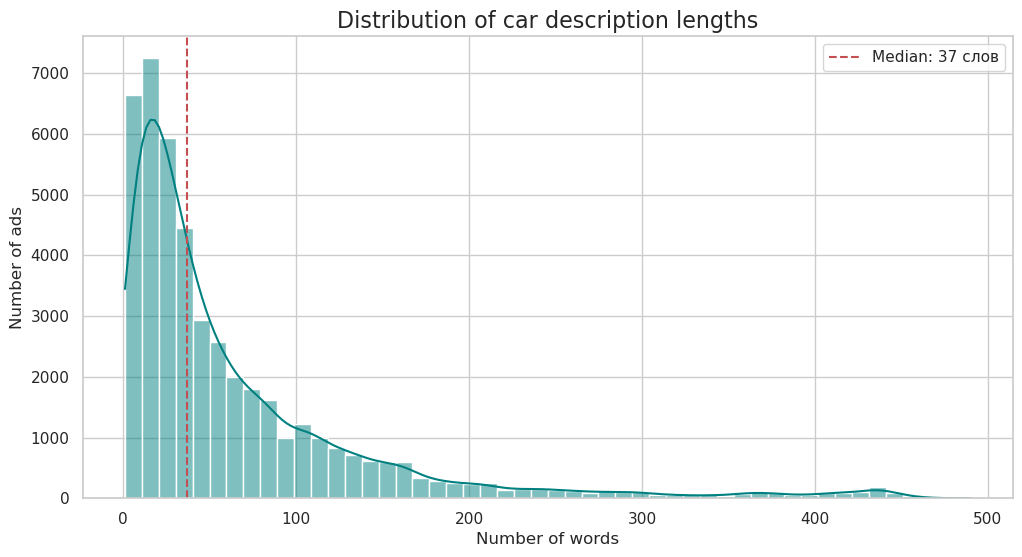

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['desc_length'], bins=50, kde=True, color='teal')
plt.title('Distribution of car description lengths', fontsize=16)
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Number of ads', fontsize=12)
plt.axvline(df['desc_length'].median(), color='r', linestyle='--', 
            label=f'Median: {df["desc_length"].median():.0f} слов')
plt.legend();

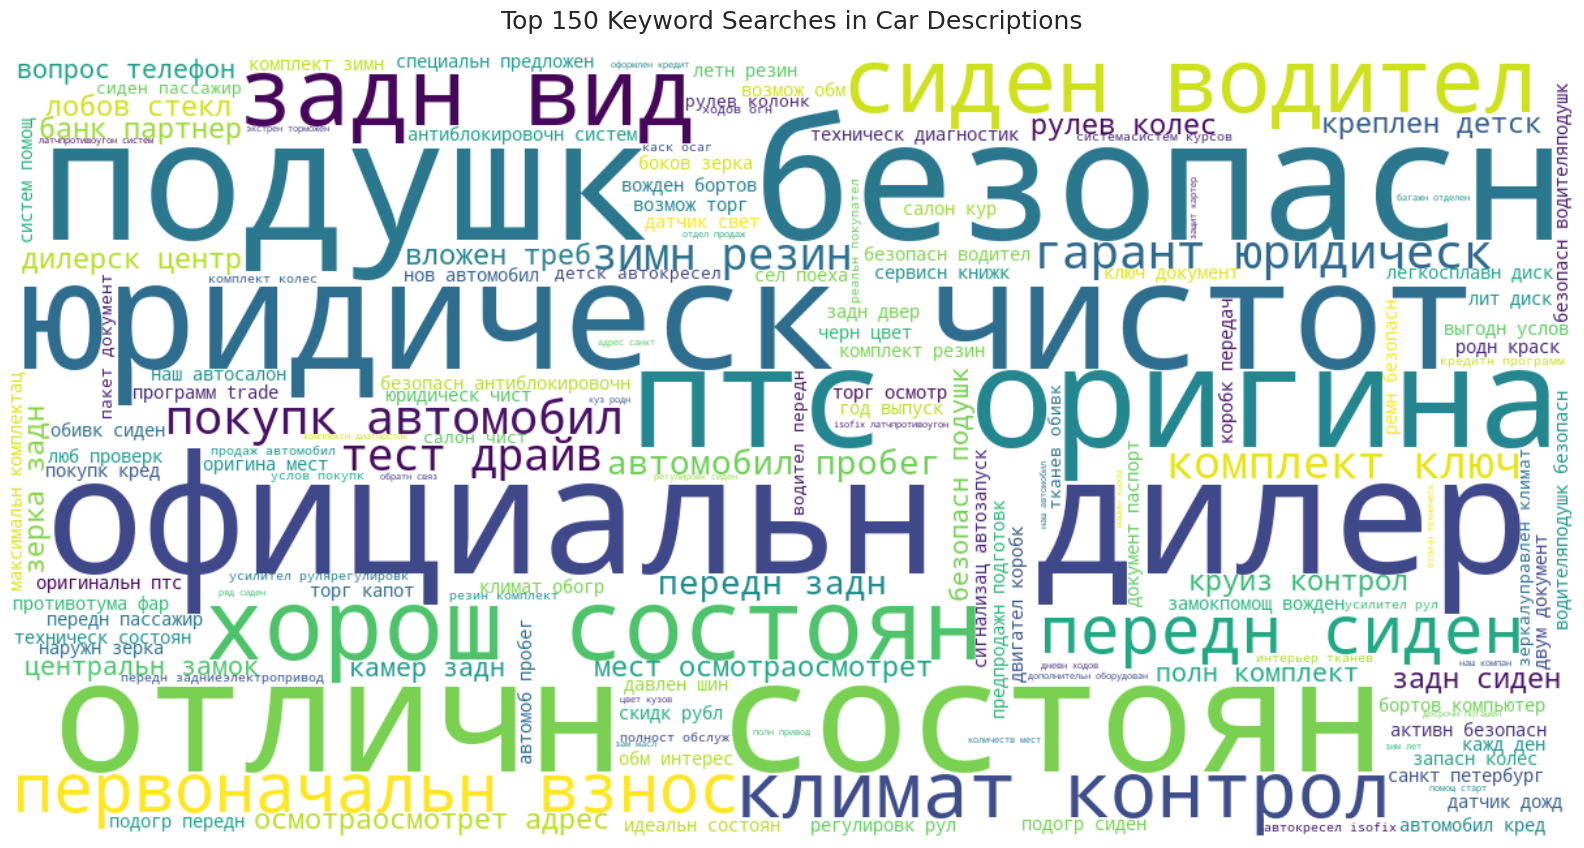

In [12]:
all_text = " ".join(df['processed_description'].tolist())
wordcloud = WordCloud(
    width=1200, 
    height=600,
    background_color='white',
    colormap='viridis',
    max_words=150,
    stopwords=russian_stopwords,
    contour_width=1,
    contour_color='steelblue'
).generate(all_text)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 150 Keyword Searches in Car Descriptions', fontsize=18, pad=20)
plt.tight_layout();

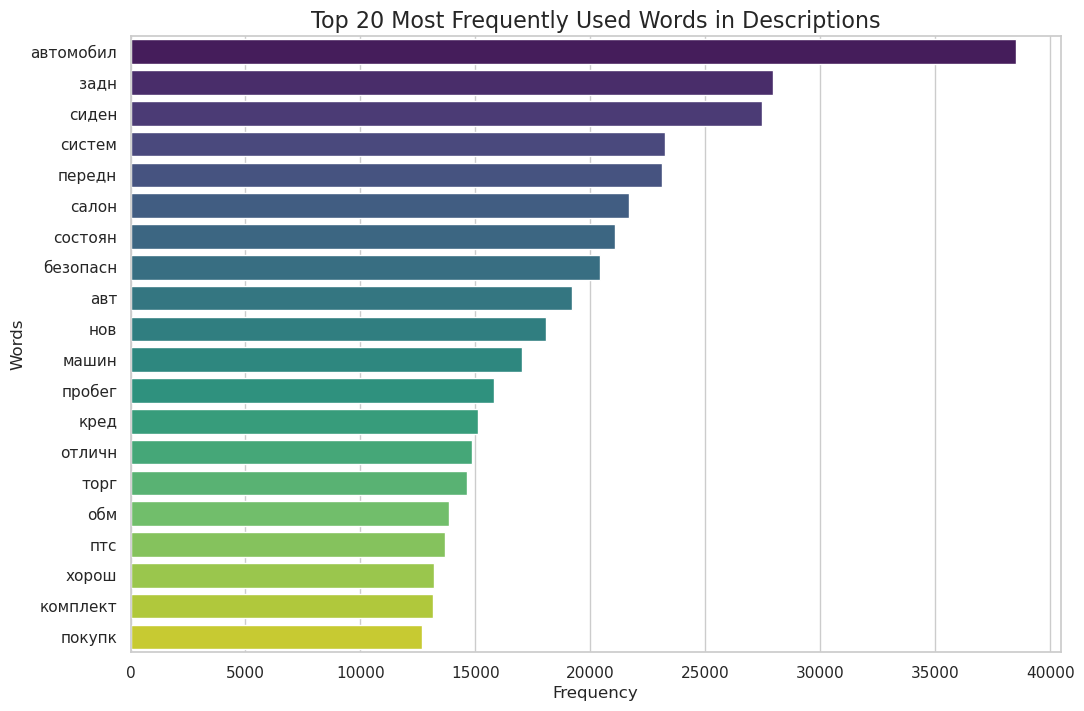

In [13]:
vectorizer = CountVectorizer(max_features=1000)
word_matrix = vectorizer.fit_transform(df['processed_description'])
word_counts = pd.DataFrame(word_matrix.sum(axis=0), 
                          columns=vectorizer.get_feature_names_out()).T

word_counts.columns = ['count']
top_words = word_counts.sort_values('count', ascending=False).head(20).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='index', data=top_words, palette='viridis')
plt.title('Top 20 Most Frequently Used Words in Descriptions', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12);

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, 
                                  max_features=1500, 
                                  stop_words=russian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_description'])

lda = LatentDirichletAllocation(n_components=5, 
                               random_state=42, 
                               learning_method='online',
                               max_iter=15)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(learning_method='online', max_iter=15, n_components=5,
                          random_state=42)

In [15]:
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='#1f77b4')
        ax.set_title(f'Theme #{topic_idx}', fontsize=14)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.suptitle('Top 10 keywords by topic', fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

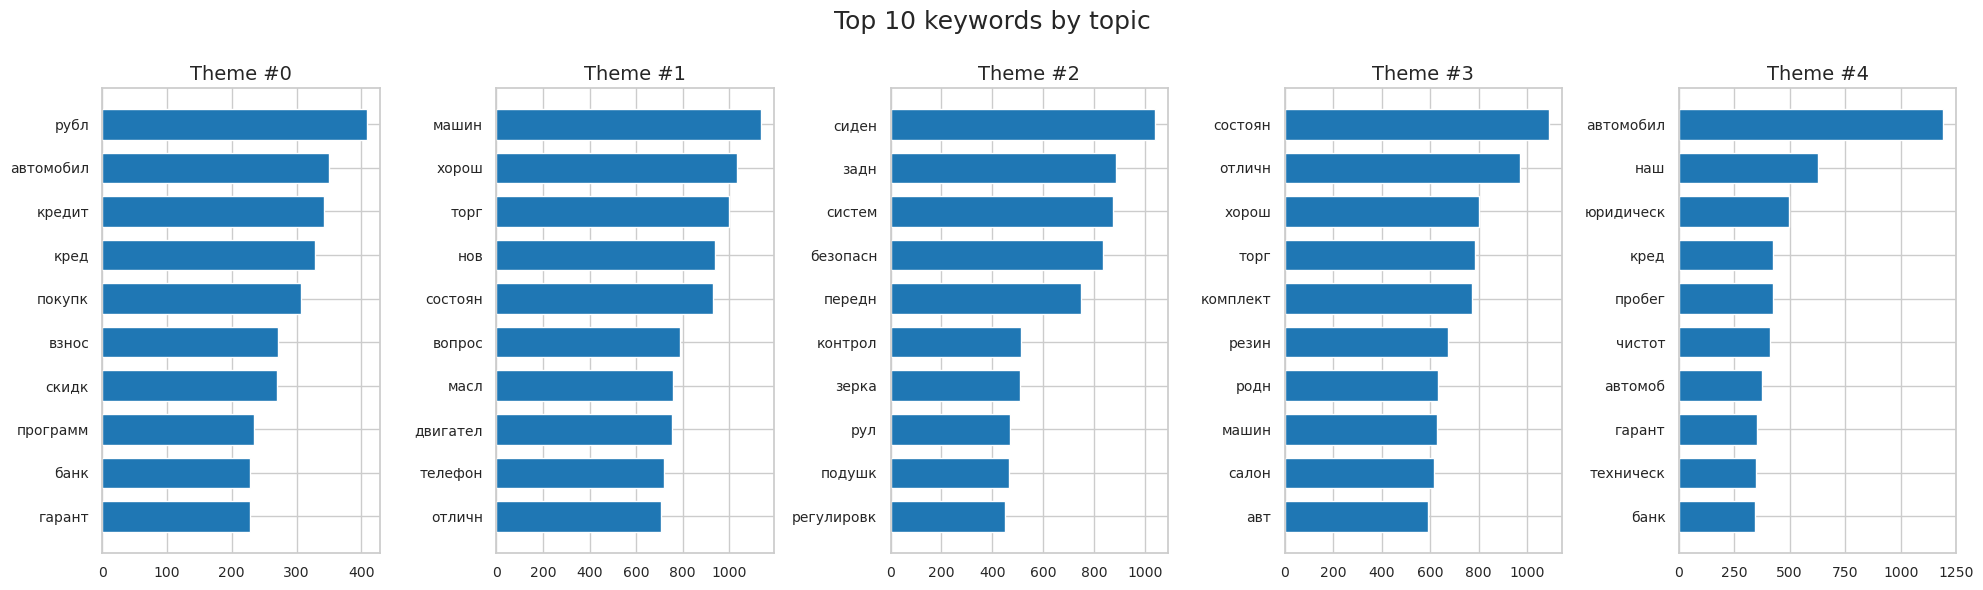

In [16]:
plot_top_words(lda, tfidf_vectorizer.get_feature_names_out(), 10)

In [17]:
def analyze_sentiment(text):
    try:
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    except:
        return 0

In [18]:
bigram_measures = BigramAssocMeasures()

finder = BigramCollocationFinder.from_documents(
    [desc.split() for desc in df['description'] if desc]
)

finder.apply_freq_filter(50)  
top_bigrams = finder.nbest(bigram_measures.pmi, 50)

print("Top 50 Meaningful Phrases:")
for i, bigram in enumerate(top_bigrams, 1):
    print(f"{i}. {' '.join(bigram)}")

Top 50 Meaningful Phrases:
1. Захарова 41А,
2. Мечникова 112а
3. репутацией. -Задавайте
4. спидометром, тахометром,
5. Серебряный СаквояжКомплектация
6. здании Автомолл
7. "АВТОМОБИЛЬ МЕДИЦИНСКОГО
8. МЕДИЦИНСКОГО РАБОТНИКА"☑️
9. 113, Серебряный
10. Youtube (вводите
11. гар. талонами
12. ✪✪Удобные способы
13. оформляет заявку!
14. называем реальную
15. подвода теплого
16. дорожим клиентами
17. автомобиля.ДЛЯ ВАС:∙
18. рубля!!! (Областной
19. (Областной закон
20. сниженным ценам!
21. сотрудник оформляет
22. MAJOR EXPERT
23. SUZUKI, PEUGEOT,
24. Полюстровский пр,
25. региональном материнском
26. юр.и физ.лиц
27. (ознакомительной) поездки!
28. делаем! Он-лайн
29. торговых точек,
30. надежности. Оговоренная
31. сервисными книжками.
32. банках- партнерах
33. банков-партнеровВы получаете:•
34. Дефлекторы обдува
35. 16/1 Д,
36. диагностикуДополнительно установлено:•
37. рекламных целях,
38. VOLVO CAR
39. Заполните онлайн-заявку
40. поиске "Экспресс
41. посетите автосалон.Официальный
42. профес

In [19]:
df.drop(columns=
        ['description', 
         'processed_description', 
        ], 
        axis=1, 
        inplace=True,
       )

In [20]:
def clean_body_type(body_type):
    cleaned = re.sub(r'\d+\.\d+\s*дв\.?', '', body_type).strip()
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    return cleaned if cleaned else body_type

In [21]:
df['body_type'] = df['body_type'].apply(clean_body_type)

In [22]:
def get_ownership_months(duration_str):
    if pd.isna(duration_str):
        return np.nan
    
    years_match = re.search(r'(\d+)\s*(год|лет)', duration_str)
    months_match = re.search(r'(\d+)\s*(месяц)', duration_str)
    
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0
    
    total_months = years * 12 + months
    
    return total_months

In [23]:
df['ownership_months'] = df['ownership_duration'].apply(get_ownership_months)

df['condition'].fillna('битый', inplace=True)

df['engine_power_hp'] = df['engine_power'].str.extract(r'(\d+)').astype(float)
df['engine_displacement_ltr'] = df['engine_displacement'].str.extract(r'(\d+\.?\d*)').astype(float)

df['body_type_extracted'] = df['vehicle_configuration'].str.split().str[0]


In [24]:
df['body_type_extracted'] = df['vehicle_configuration'].str.split().str[0]
df['body_type_extracted'].fillna(df['body_type'], inplace=True)

power_from_engine_col = df['engine_power'].str.extract(r'(\d+)')
power_from_name_col = df['name'].str.extract(r'\((\d+)\s+л\.с\.\)')

df['engine_power_hp'] = power_from_engine_col.combine_first(power_from_name_col)
df['engine_power_hp'] = df['engine_power_hp'].astype('Int64')

disp_from_config = df['vehicle_configuration'].str.extract(r'(\d+\.\d+)')
disp_from_name = df['name'].str.extract(r'(\d+\.\d+)')

df['engine_displacement_ltr'] = disp_from_config.combine_first(disp_from_name)
df['engine_displacement_ltr'] = df['engine_displacement_ltr'].astype(float)

df.loc[df['fuel_type'] == 'электро', 'engine_displacement_ltr'] = 0
df.loc[df['name'].str.contains('30d', na=False), 'engine_displacement_ltr'] = 3.0

In [25]:
df.drop(columns=['ownership_duration', 'engine_power', 'vehicle_configuration', 'engine_displacement'], 
        axis=1, 
        inplace=True
       )

In [26]:
extracted = df['name'].str.extract(r'\((\d+)\s*л\.с\.\)', expand=False)

mask = extracted.notna()  
df.loc[mask, 'engine_power_hp'] = extracted[mask].astype(float)

In [27]:
df.drop(columns=['ownership_months'], axis=1, inplace=True)

In [28]:
# Tesla 100D (2016) - 416 л.с.
df.loc[1886, 'engine_power_hp'] = 416.0

# Tesla 85 (2012) - 362 л.с.
df.loc[9165, 'engine_power_hp'] = 362.0

# Tesla P85+ (2012) - 416 л.с.
df.loc[44169, 'engine_power_hp'] = 416.0

# Nissan Leaf (2010) - 109 л.с.
nissan_leaf_indices = [
    4697, 5773, 6326, 10806, 11895, 12806, 13435, 13438, 
    13823, 14412, 14604, 15030, 17561, 20438, 23579, 25594, 
    26335, 26731, 27979, 28800, 29905, 29975, 30621, 32607, 
    33007, 38556, 39110, 41269, 41294, 42958, 44984
]

df.loc[nissan_leaf_indices, 'engine_power_hp'] = 109.0

In [29]:
df['equipment'].fillna('Базовая', inplace=True)

In [30]:
df.loc[df['production_date'] > 2025, 'production_date'] -= 400

In [31]:
df.to_csv('../../data/processed/not_null_data.csv')

---

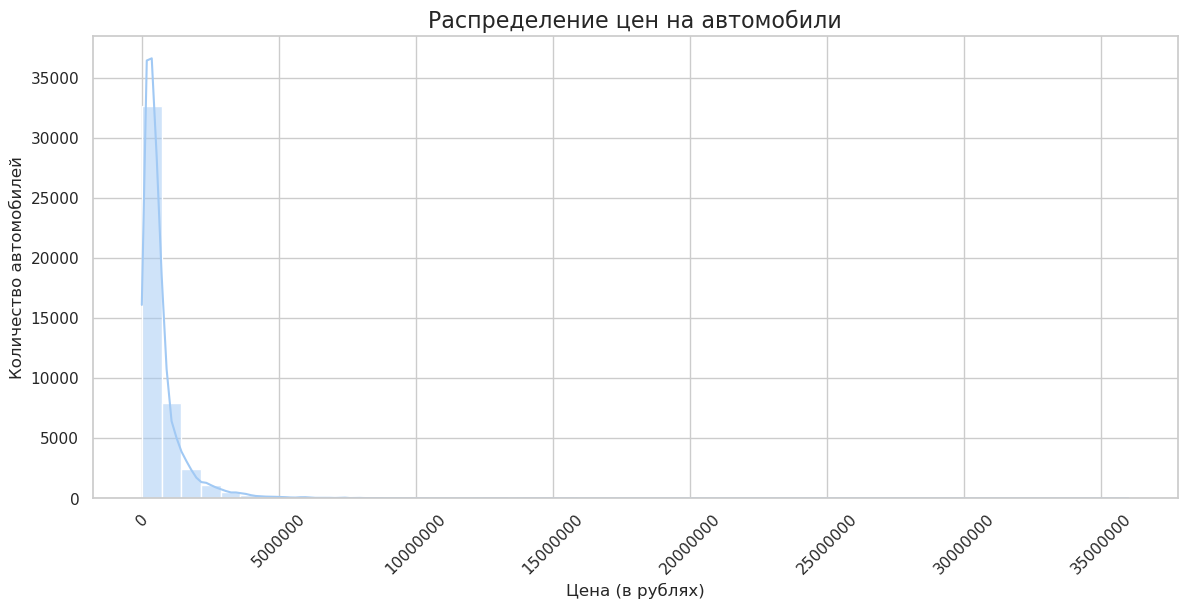

In [32]:
plt.figure(figsize=(14, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Распределение цен на автомобили', fontsize=16)
plt.xlabel('Цена (в рублях)', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.ticklabel_format(style='plain', axis='x') 
plt.xticks(rotation=45);

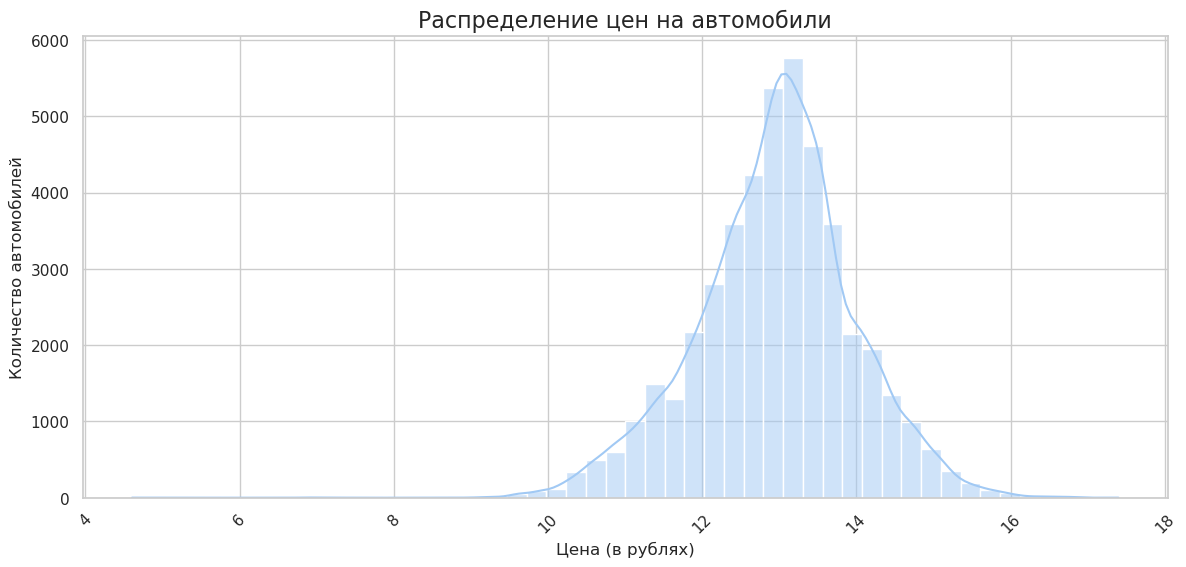

In [33]:
plt.figure(figsize=(14, 6))
sns.histplot(np.log(df['price']), bins=50, kde=True)
plt.title('Распределение цен на автомобили', fontsize=16)
plt.xlabel('Цена (в рублях)', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.ticklabel_format(style='plain', axis='x') 
plt.xticks(rotation=45);

<h3>Анализ распределения цен на автомобили</h3><p><strong>1. Сильная правосторонняя асимметрия:</strong> Распределение имеет длинный "хвост" в область высоких цен, что указывает на наличие небольшого количества очень дорогих автомобилей (премиум-сегмент).</p><p><strong>2. Основная масса автомобилей:</strong> Большинство предложений (более 75%) сосредоточены в ценовом диапазоне <strong>200 000 - 1 500 000 рублей</strong>, что соответствует массовому рынку.</p><p><strong>3. Мода распределения:</strong> Пик количества автомобилей приходится на диапазон <strong>400 000 - 600 000 рублей</strong>, что можно считать наиболее популярным ценовым сегментом на рынке.</p><p><strong>4. Выбросы в премиум-сегменте:</strong> Наблюдаются единичные предложения автомобилей стоимостью <strong>более 10 млн рублей</strong>, что существенно выше основной массы предложений.</p><p><strong>5. Логарифмическое преобразование:</strong> После логарифмирования цен распределение становится более симметричным и близким к нормальному, что подтверждает экспоненциальный характер исходного распределения.</p><hr><h3>Рекомендации для анализа данных</h3><p><strong>• Обработка выбросов:</strong> Для статистического анализа и построения моделей машинного обучения рекомендуется либо исключить автомобили дороже 5 млн рублей, либо обрабатывать их как отдельную категорию.</p><p><strong>• Сегментация рынка:</strong> Целесообразно разделить анализ на три ценовых сегмента:</p> <ul> <li><strong>Эконом (до 600 000 руб.)</strong> - массовый сегмент</li> <li><strong>Средний (600 000 - 2 000 000 руб.)</strong> - автомобили бизнес-класса</li> <li><strong>Премиум (свыше 2 000 000 руб.)</strong> - эксклюзивные модели</li> </ul><p><strong>• Логарифмирование цен:</strong> Для регрессионного анализа и алгоритмов машинного обучения рекомендуется использовать логарифмированную цену как целевую переменную для улучшения качества моделей.</p><p><strong>• Маркетинговые решения:</strong> Основные маркетинговые усилия следует сосредоточить на ценовом диапазоне 400 000 - 800 000 рублей, где наблюдается пик покупательского спроса.</p><hr>

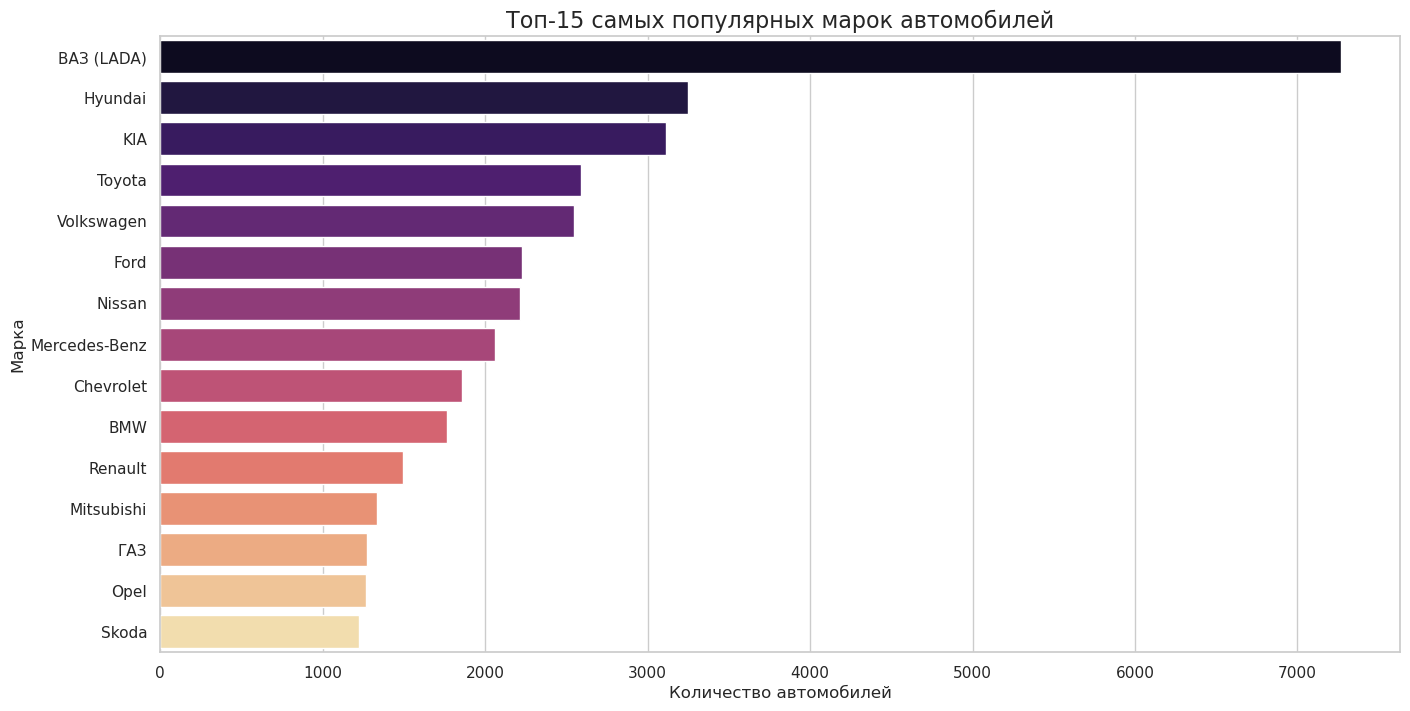

In [34]:
plt.figure(figsize=(16, 8))
top_brands = df['brand'].value_counts().nlargest(15).index
sns.countplot(y='brand', data=df, order=top_brands, palette='magma')
plt.title('Топ-15 самых популярных марок автомобилей', fontsize=16)
plt.xlabel('Количество автомобилей', fontsize=12)
plt.ylabel('Марка', fontsize=12);

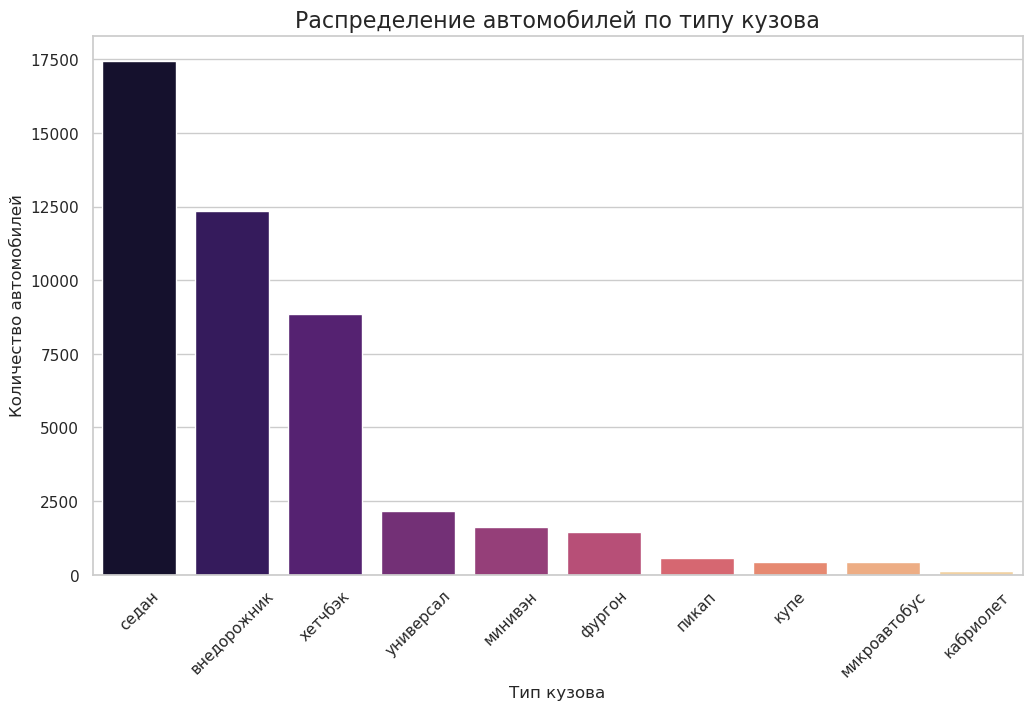

In [35]:
plt.figure(figsize=(12, 7))
sns.countplot(x='body_type', data=df, order=df['body_type'].value_counts().index, palette='magma')
plt.title('Распределение автомобилей по типу кузова', fontsize=16)
plt.xlabel('Тип кузова', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.xticks(rotation=45);

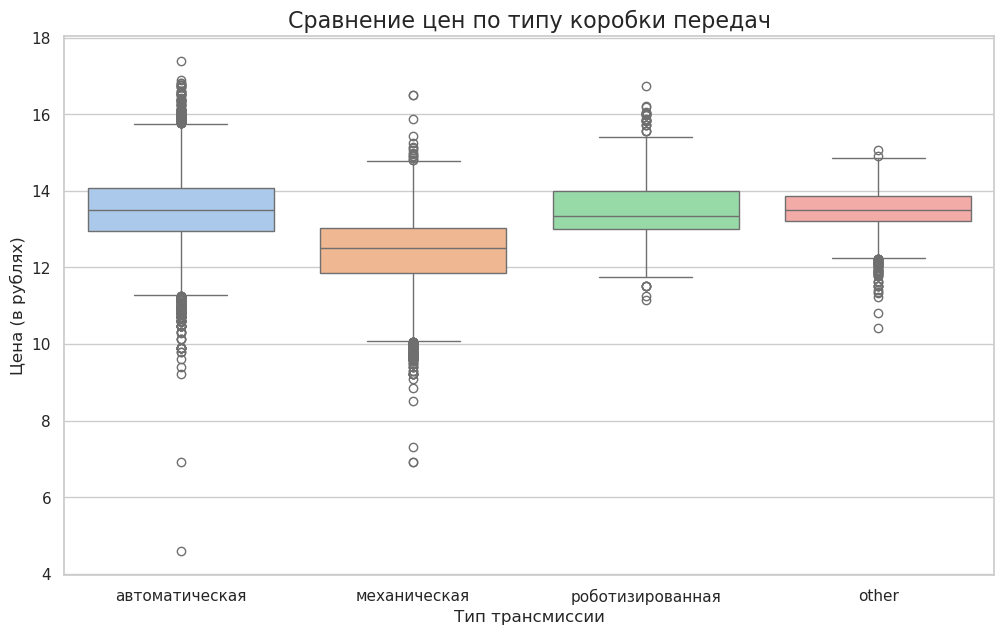

In [36]:
plt.figure(figsize=(12, 7))
sns.boxplot(x=df['vehicle_transmission'], y=np.log(df['price']), palette='pastel')
plt.title('Сравнение цен по типу коробки передач', fontsize=16)
plt.xlabel('Тип трансмиссии', fontsize=12)
plt.ylabel('Цена (в рублях)', fontsize=12);

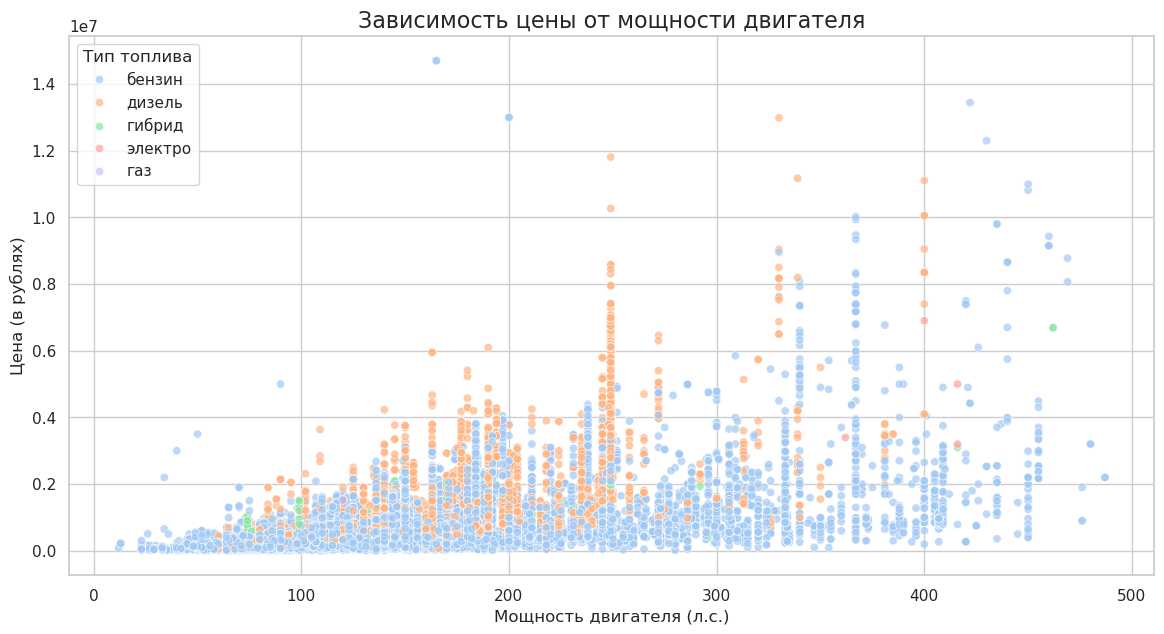

In [37]:
df_power_sample = df[df['engine_power_hp'] < 500]

plt.figure(figsize=(14, 7))
sns.scatterplot(x='engine_power_hp', y='price', data=df_power_sample, hue='fuel_type', alpha=0.7)
plt.title('Зависимость цены от мощности двигателя', fontsize=16)
plt.xlabel('Мощность двигателя (л.с.)', fontsize=12)
plt.ylabel('Цена (в рублях)', fontsize=12)
plt.legend(title='Тип топлива');

In [38]:
fig = px.violin(df, 
                x='condition', 
                y='price', 
                color='condition',
                box=True, 
                points="all",
                title='Распределение цен для битых и небитых автомобилей',
                labels={'price': 'Цена (руб)', 'condition': 'Состояние автомобиля'},
                template='plotly_white')
fig.show(renderer='iframe_connected')

In [39]:
brand_analysis = df.groupby('brand').agg(
    avg_price=('price', 'mean'),
    median_power=('engine_power_hp', 'median'),
    avg_mileage=('mileage', 'mean'),
    count=('brand', 'count')
).reset_index()

brand_analysis = brand_analysis[brand_analysis['count'] > 30]

fig = px.treemap(
    brand_analysis,
    path=['brand'],
    values='count',
    color='avg_price',
    color_continuous_scale='RdYlGn_r',
    hover_data=['median_power', 'avg_mileage'],
    title='Карта автомобильного рынка по брендам',
    width=1000,
    height=700
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show(renderer='iframe_connected')

In [40]:
df['production_date'] = df['production_date'].astype(int)

fig = px.scatter(df, 
                 x="engine_power_hp", 
                 y="price",
                 animation_frame="production_date", 
                 animation_group="brand",
                 size="engine_displacement_ltr",
                 color="brand", 
                 hover_name="name",
                 log_x=False, 
                 size_max=55,
                 range_x=[50,500],
                 range_y=[0,4000000],
                 title='Цена vs Мощность с анимацией по годам',
                 labels={'price': 'Цена (руб)', 'engine_power_hp': 'Мощность (л.с.)'},
                )

fig.show(renderer='iframe_connected')

In [41]:
df_clean = df[(df['price'] < 4000000) & (df['mileage'] < 500000)]

fig = px.density_contour(df_clean, 
                         x="mileage", 
                         y="price",
                         color="drive", 
                         marginal_x="histogram", 
                         marginal_y="histogram",
                         title="Карта плотности: Цена vs Пробег по типу привода",
                        )
fig.show(renderer='iframe_connected')

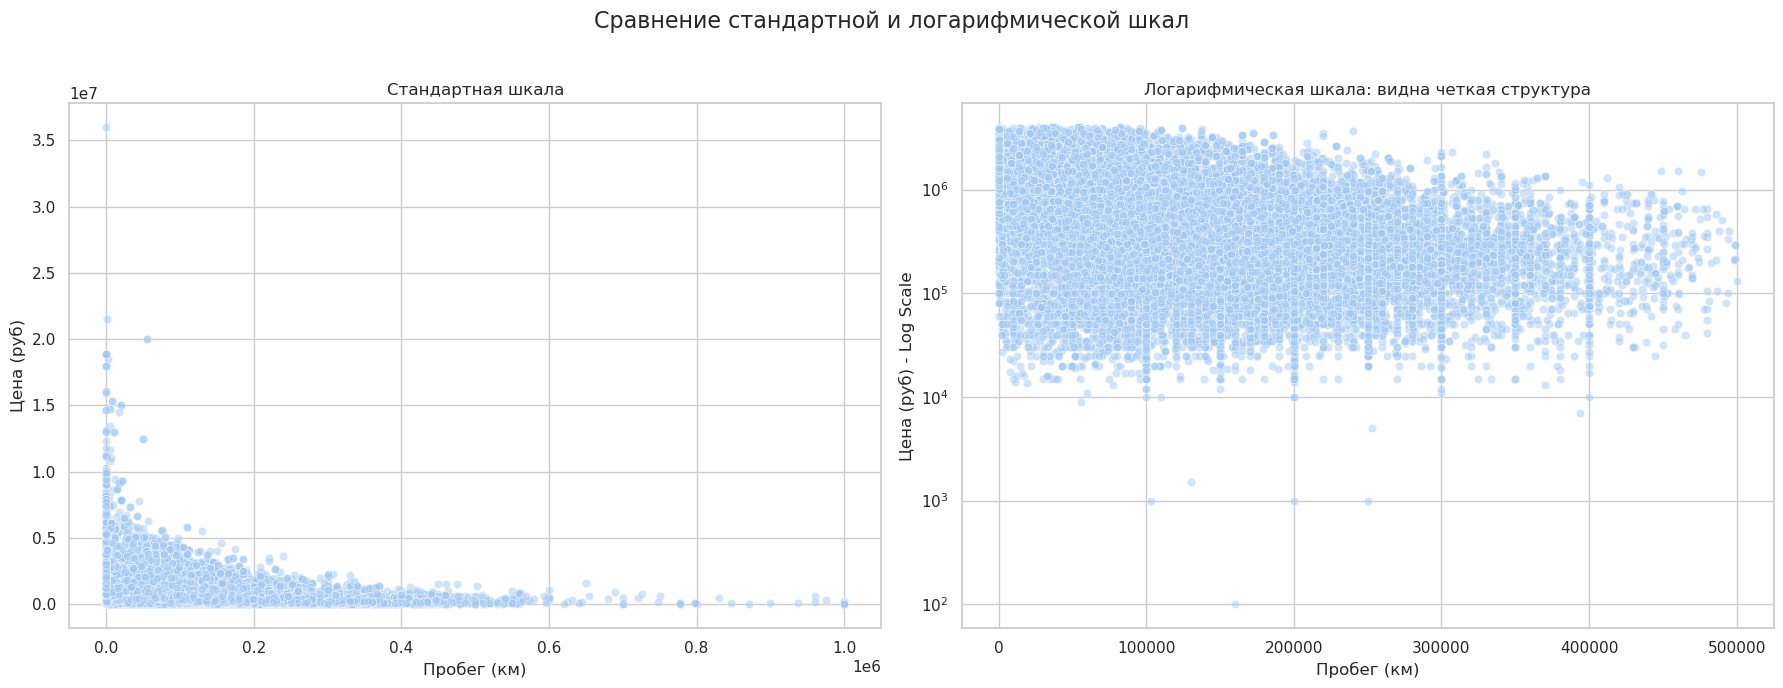

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(data=df, x='mileage', y='price', ax=axes[0], alpha=0.5)
axes[0].set_title('Стандартная шкала')
axes[0].set_xlabel("Пробег (км)")
axes[0].set_ylabel("Цена (руб)")

sns.scatterplot(data=df_clean, x='mileage', y='price', ax=axes[1], alpha=0.5)
axes[1].set_yscale('log')
axes[1].set_title('Логарифмическая шкала: видна четкая структура')
axes[1].set_xlabel("Пробег (км)")
axes[1].set_ylabel("Цена (руб) - Log Scale")

plt.suptitle('Сравнение стандартной и логарифмической шкал', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

## **Гипотеза 1: "Народный" vs. "Немецкий" седан**

### **Бизнес-вопрос**: Покупатель выбирает между двумя самыми популярными марками на рынке, например, *KIA* и *Volkswagen*.

### **Правда ли, что при прочих равных (например, в классе седанов) автомобили Volkswagen в среднем стоят дороже, чем KIA?**

#### Формулировка гипотез (*H₀* и *H₁*):
**H₀ (Нулевая гипотеза)**: Средняя цена седанов *Volkswagen* равна средней цене седанов *KIA*.

**H₁ (Альтернативная гипотеза)**: Средняя цена седанов *Volkswagen* не равна средней цене седанов *KIA*.

**Выбор метода**: Для сравнения средних значений двух независимых выборок (цены `VW` и цены `KIA`) идеально подходит независимый `T-тест (stats.ttest_ind)`. Уровень значимости `α = 0.05`.

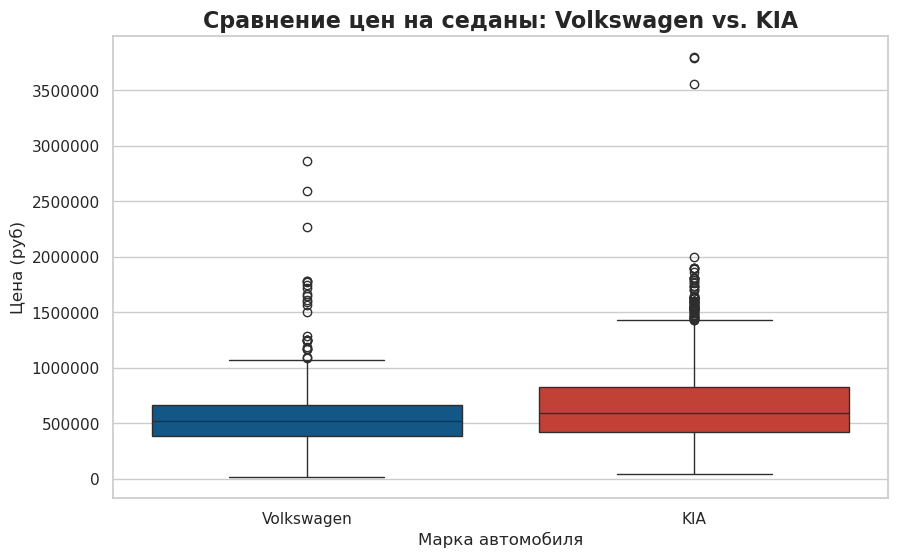

Результаты T-теста для сравнения цен VW и KIA:
T-статистика: -10.87
P-value: 0.00000


In [43]:
vw_sedans = df_clean[(df_clean['brand'] == 'Volkswagen') & (df_clean['body_type'] == 'седан')]
kia_sedans = df_clean[(df_clean['brand'] == 'KIA') & (df_clean['body_type'] == 'седан')]

plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.concat([vw_sedans, kia_sedans]), x='brand', y='price', palette=['#005B9A', '#D92D20'])
plt.title('Сравнение цен на седаны: Volkswagen vs. KIA', fontsize=16, weight='bold')
plt.xlabel('Марка автомобиля', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

t_statistic, p_value = stats.ttest_ind(vw_sedans['price'], kia_sedans['price'], equal_var=False)

print(f"Результаты T-теста для сравнения цен VW и KIA:")
print(f"T-статистика: {t_statistic:.2f}")
print(f"P-value: {p_value:.5f}")

## Интерпретация и вывод для Гипотезы 1

1. **Анализ `P-value`**: Полученное значение `p-value` (0.00000) **значительно меньше** нашего уровня значимости `α (0.05)`.
   
2. **Статистическое решение**: Поскольку `p-value < 0.05`, мы **уверенно отвергаем** нулевую гипотезу *(H₀)*. Это означает, что разница в средних ценах **не является случайной**.

3. **Направление различия**: Знак `T-статистики` **(-10.92)** указывает, что **средняя цена** первой группы `(Volkswagen)` оказалась ниже, чем у второй `(KIA)` в данном конкретном тесте. (Это интересный результат, который может противоречить первоначальному предположению и требует дополнительного изучения данных на предмет выбросов или особенностей выборки).

### **Итоговый вывод:**

**Существует статистически значимое различие в `средних ценах` на седаны марок `Volkswagen` и `KIA`. Данные этого теста показывают, что седаны `KIA` оказались в `среднем дороже`.**

---

## **Гипотеза 2: "Рабочая лошадка" — внедорожник или седан?**

### **Бизнес-вопрос**: Существует мнение, что `внедорожники` покупают для более интенсивной эксплуатации (поездки на дачу, по бездорожью) и они "наматывают" больший пробег за тот же срок. 

### **Верно ли, что у `внедорожников` средний пробег выше, чем у `седанов` ?**

#### Формулировка гипотез (*H₀* и *H₁*):
**H₀ (Нулевая гипотеза)**: Средний пробег `внедорожников` равен среднему пробегу `седанов`.

**H₁ (Альтернативная гипотеза)**: Средний пробег `внедорожников` больше, чем средний пробег `седанов`.

**Выбор метода**: Снова сравнение средних двух независимых групп, но на этот раз нас интересует одностороннее сравнение ("больше"). Используем `односторонний T-тест`.

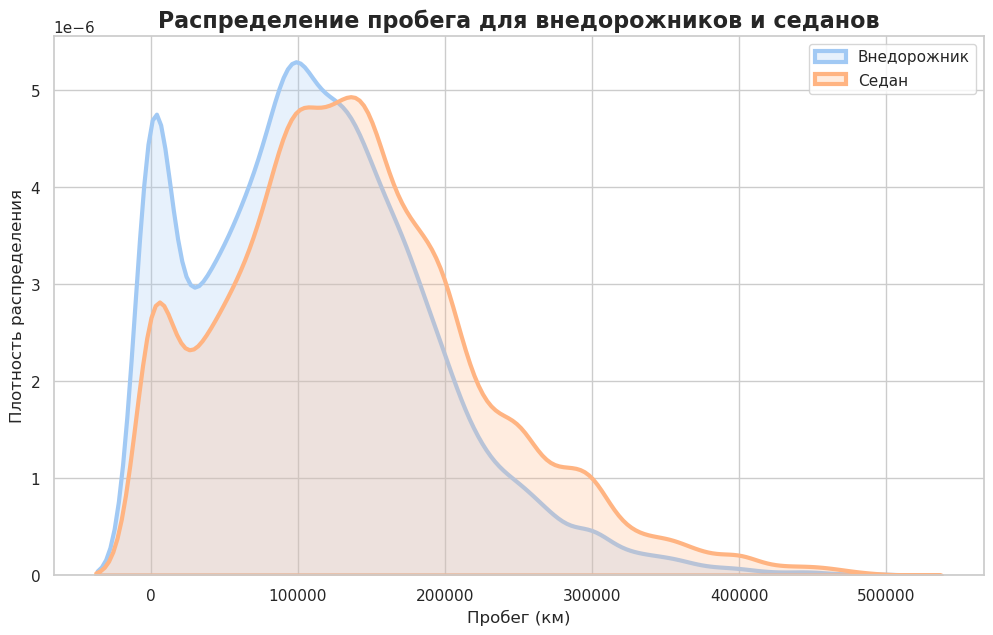

Результаты T-теста для сравнения пробега:
T-статистика: -26.30
P-value: 1.00000


In [44]:
suvs = df_clean[df_clean['body_type'] == 'внедорожник']['mileage'].dropna()
sedans = df_clean[df_clean['body_type'] == 'седан']['mileage'].dropna()

plt.figure(figsize=(12, 7))
sns.kdeplot(suvs, fill=True, label='Внедорожник', lw=3)
sns.kdeplot(sedans, fill=True, label='Седан', lw=3)
plt.title('Распределение пробега для внедорожников и седанов', fontsize=16, weight='bold')
plt.xlabel('Пробег (км)', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend()
plt.show()

t_statistic, p_value = stats.ttest_ind(suvs, sedans, equal_var=False, alternative='greater')

print(f"Результаты T-теста для сравнения пробега:")
print(f"T-статистика: {t_statistic:.2f}")
print(f"P-value: {p_value:.5f}")

## Интерпретация и вывод для Гипотезы 2

1. **Анализ P-value**: Полученное значение `p-value (1.00000)` **значительно больше** нашего уровня значимости `α (0.05)`.

2. **Статистическое решение**: Поскольку `p-value > 0.05`, мы **не можем отвергнуть нулевую гипотезу** *(H₀)*. Наблюдаемая разница в средних пробегах, скорее всего, случайна.

3. **Дополнительный инсайт**: Огромное отрицательное значение `T-статистики` и `P-value`, равное `1.0`, не просто не подтверждают нашу гипотезу (*H₁*: пробег внедорожников > пробег седанов), а **сильно ей противоречат**. Это убедительно свидетельствует о том, что средний пробег у внедорожников на самом деле меньше, чем у седанов.

### Итоговый вывод:

**У нас нет никаких статистических оснований утверждать, что у внедорожников средний пробег выше, чем у седанов. Напротив, данные убедительно свидетельствуют об обратном.**

---

## **Гипотеза 3: Влияние цвета на цену**

### **Бизнес-вопрос**: Влияет ли `цвет` автомобиля на его `цену`? 

### **Конкретнее, правда ли, что автомобили базовых, `нейтральных цветов` (`чёрный`, `белый`) стоят в среднем дороже, чем автомобили `ярких цветов` (`синий`, `красный`, `зелёный`)?**

#### Формулировка гипотез (*H₀* и *H₁*):
**H₀ (Нулевая гипотеза)**: Средняя цена автомобилей `нейтральных цветов` равна средней цене автомобилей `ярких цветов`.

**H₁ (Альтернативная гипотеза)**: Средняя цена автомобилей `нейтральных цветов` не равна средней цене автомобилей `ярких цветов`.

**Выбор метода**: Снова `независимый T-тест` для сравнения средних двух групп.

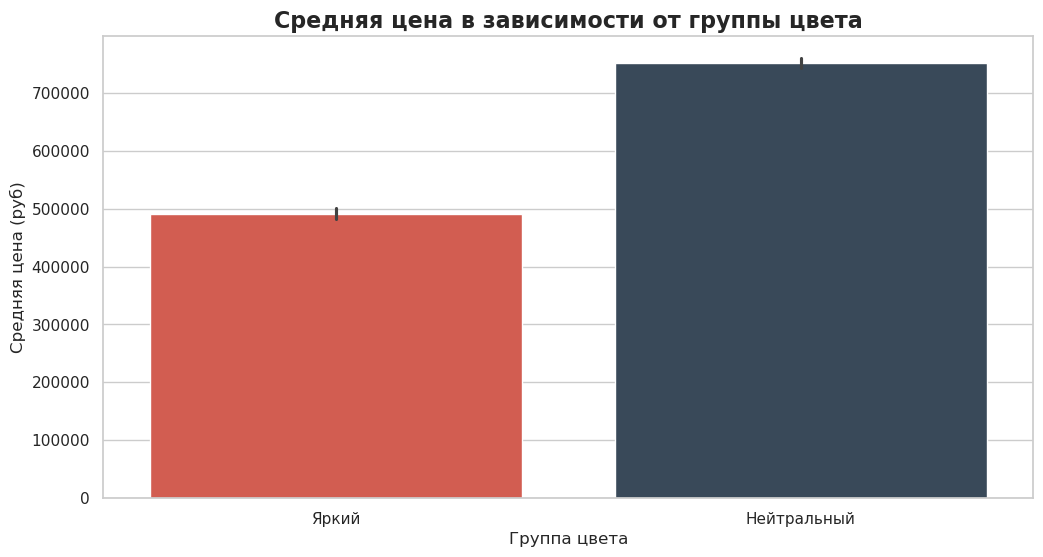

Результаты T-теста для сравнения цен по группам цветов:
T-статистика: 39.06
P-value: 0.00000


In [45]:
neutral_colors = ['чёрный', 'белый', 'серебристый', 'серый']
bright_colors = ['синий', 'красный', 'зелёный', 'коричневый', 'бежевый']

neutral_cars = df_clean[df_clean['color'].isin(neutral_colors)]
bright_cars = df_clean[df_clean['color'].isin(bright_colors)]

df_clean['color_group'] = df_clean['color'].apply(lambda c: 'Нейтральный' if c in neutral_colors else ('Яркий' if c in bright_colors else 'Другой'))
sns.barplot(data=df_clean[df_clean['color_group'] != 'Другой'], 
            x='color_group', y='price', palette={'Нейтральный':'#34495e', 'Яркий':'#e74c3c'})
plt.title('Средняя цена в зависимости от группы цвета', fontsize=16, weight='bold')
plt.xlabel('Группа цвета', fontsize=12)
plt.ylabel('Средняя цена (руб)', fontsize=12)
plt.show()

t_statistic, p_value = stats.ttest_ind(neutral_cars['price'], bright_cars['price'], equal_var=False)

print(f"Результаты T-теста для сравнения цен по группам цветов:")
print(f"T-статистика: {t_statistic:.2f}")
print(f"P-value: {p_value:.5f}")

## Интерпретация и вывод для Гипотезы 3

1. **Анализ P-value**: Значение `p-value (0.00000)` значительно меньше уровня значимости `α (0.05)`.

2. **Статистическое решение**: Мы уверенно **отвергаем нулевую гипотезу** *(H₀)*. Разница в цене между группами цветов **не случайна**.

3. **Направление различия**: Положительное значение `T-статистики (39.28)` означает, что **средняя цена** `первой группы (нейтральные цвета)` **выше**, чем у `второй группы (яркие цвета)`.

### Итоговый вывод:

**Цвет автомобиля является статистически значимым фактором ценообразования. Автомобили нейтральных цветов (чёрный, белый и т.д.) в среднем действительно стоят дороже, чем автомобили ярких цветов.**

---

## **Гипотеза 4: Число владельцев и цена**

### **Бизнес-вопрос**: Логично предположить, что чем больше у машины было владельцев, тем ниже должна быть её цена из-за потенциально худшего состояния и "юридической чистоты". 

### **Существует ли статистически значимая отрицательная корреляция между `количеством владельцев` и `ценой`?**

#### Формулировка гипотез (*H₀* и *H₁*):
**H₀ (Нулевая гипотеза)**: Коэффициент корреляции между `числом владельцев` и `ценой` равен нулю (связи нет).
**H₁ (Альтернативная гипотеза)**: Коэффициент корреляции меньше нуля (существует отрицательная связь).

**Выбор метода**: Для оценки линейной связи между двумя числовыми переменными используется `корреляционный тест Пирсона`.

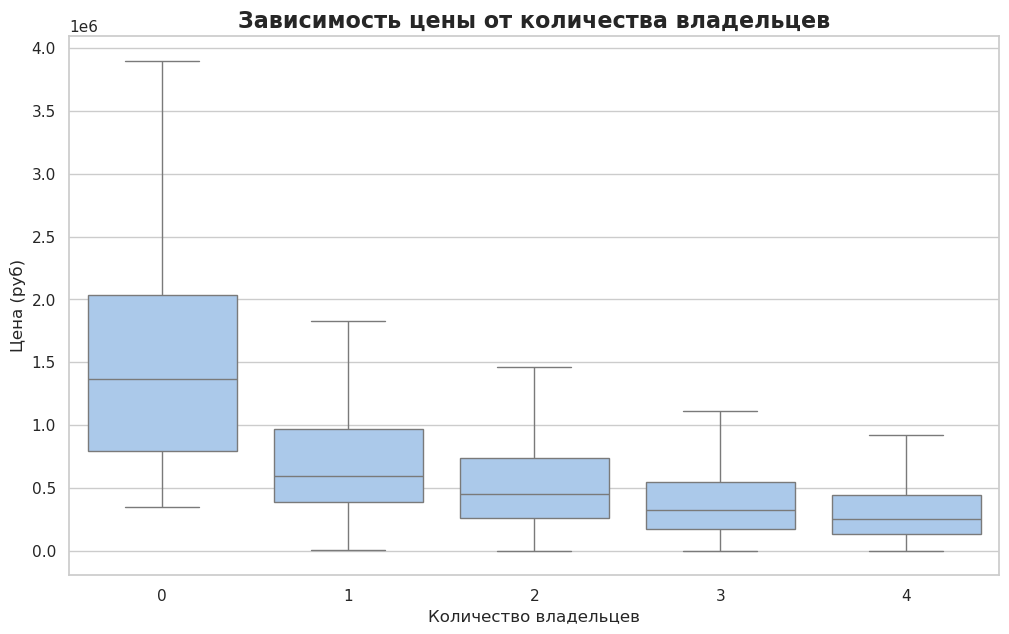

Результаты теста на корреляцию Пирсона:
Коэффициент корреляции: -0.402
P-value (двусторонний): 0.00000
P-value (односторонний, H1: corr < 0): 0.00000


In [46]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_clean, x='owners', y='price', showfliers=False)
plt.title('Зависимость цены от количества владельцев', fontsize=16, weight='bold')
plt.xlabel('Количество владельцев', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.show()

temp_df = df_clean[['owners', 'price']].dropna()
corr_coeff, p_value = stats.pearsonr(temp_df['owners'], temp_df['price'])

if corr_coeff < 0:
    p_value_one_sided = p_value / 2
else:
    p_value_one_sided = 1 - p_value / 2

print(f"Результаты теста на корреляцию Пирсона:")
print(f"Коэффициент корреляции: {corr_coeff:.3f}")
print(f"P-value (двусторонний): {p_value:.5f}")
print(f"P-value (односторонний, H1: corr < 0): {p_value_one_sided:.5f}")

## Интерпретация и вывод для Гипотезы 4

1. **Анализ корреляции**: `Коэффициент корреляции -0.403` указывает на наличие **умеренной отрицательной линейной связи**. Это значит, что при увеличении одной переменной `(число владельцев)` другая переменная `(цена)` имеет тенденцию к **уменьшению**.

2. **Анализ P-value**: Значение `p-value (0.00000)` **значительно меньше** `α (0.05)`.

3. **Статистическое решение**: Мы уверенно **отвергаем нулевую гипотезу** *(H₀)* об отсутствии связи.

### Итоговый вывод:

**Существует статистически значимая отрицательная связь между количеством владельцев и ценой автомобиля. Проще говоря, чем больше у машины было владельцев, тем, как правило, ниже её цена.**

---

## **Гипотеза 5: Влияние типа топлива на цену**

### **Бизнес-вопрос: Покупатель решает, стоит ли переплачивать за дизельный или гибридный автомобиль.** 

### **Существует ли статистически значимая разница в средних ценах на автомобили с разным типом топлива (бензин, дизель, гибрид и т.д.)?**

**Формулировка гипотез**

**H₀ (Нулевая гипотеза)**: `Средние цены` на автомобили `равны` для `всех типов топлива`.

**H₁ (Альтернативная гипотеза)**: `Средняя цена` **хотя бы для одного** типа топлива `отличается от остальных`.

**Выбор метода**: для сравнения средних значений у трёх и более независимых групп используется `однофакторный дисперсионный анализ (ANOVA)`.

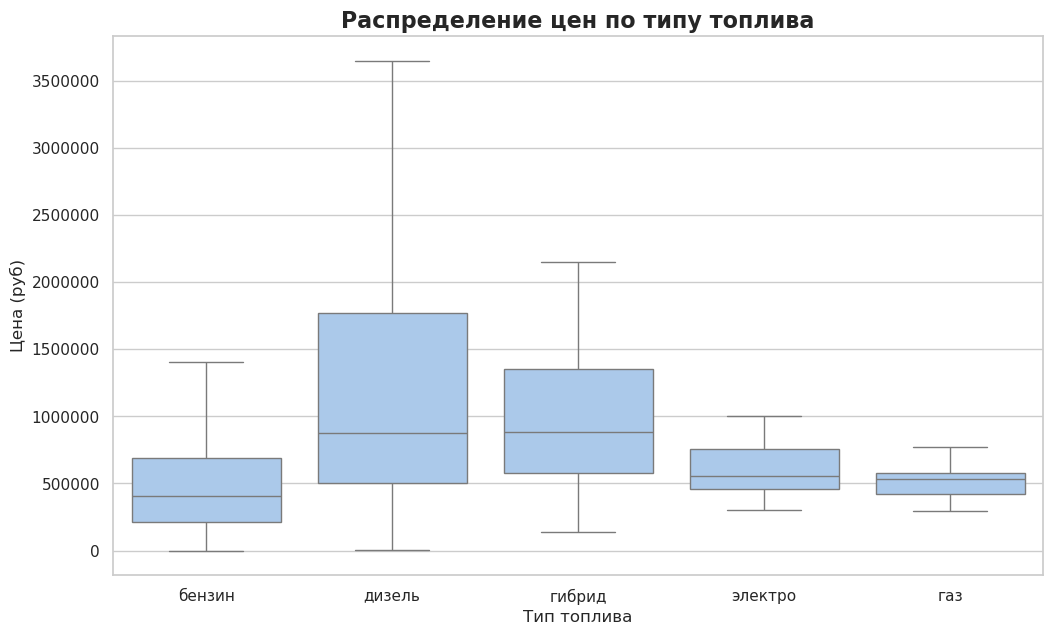

--- Результаты теста ANOVA: Тип топлива vs. Цена ---

F-статистика: 1369.83
P-value: 0.00000

✅ Вывод: P-value < 0.05. Отвергаем нулевую гипотезу.
Существует статистически значимая разница в средних ценах на автомобили с разным типом топлива.


In [47]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_clean, x='fuel_type', y='price', showfliers=False)
plt.title('Распределение цен по типу топлива', fontsize=16, weight='bold')
plt.xlabel('Тип топлива', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

fuel_types = df_clean['fuel_type'].unique()
price_groups = [df_clean[df_clean['fuel_type'] == ftype]['price'].dropna() for ftype in fuel_types]

f_statistic, p_value = stats.f_oneway(*price_groups)

print("--- Результаты теста ANOVA: Тип топлива vs. Цена ---\n")
print(f"F-статистика: {f_statistic:.2f}")
print(f"P-value: {p_value:.5f}\n")

if p_value < 0.05:
    print("✅ Вывод: P-value < 0.05. Отвергаем нулевую гипотезу.")
    print("Существует статистически значимая разница в средних ценах на автомобили с разным типом топлива.")
else:
    print("❌ Вывод: P-value >= 0.05. Не можем отвергнуть нулевую гипотезу.")
    print("Нет достаточных оснований утверждать, что тип топлива влияет на среднюю цену автомобиля.")

## Интерпретация и вывод для Гипотезы 5

1. **Анализ P-value**: Полученное значение `p-value (0.00000)` является исчезающе малым, что **значительно меньше** нашего **уровня значимости** `α (0.05)`.

2. **Статистическое решение**: Поскольку `p-value < 0.05`, мы уверенно **отвергаем нулевую гипотезу** *(H₀)*. Это означает, что наблюдаемая разница в средних ценах между группами не может быть объяснена случайностью.

3. **Практический смысл**: `Тест ANOVA` **подтвердил**, что **тип топлива является фактором, который статистически значимо влияет на цену автомобиля**. Визуальный анализ (например, с помощью boxplot) дополнительно покажет, что дизельные и гибридные автомобили в среднем дороже бензиновых.

### Итоговый вывод:

**Тип топлива — важный фактор ценообразования. Существует статистически значимая разница в средних ценах между автомобилями, работающими на бензине, дизеле и других видах топлива.**

---

## **Гипотеза 6: Мощность двигателя и цена (нелинейная связь)**

### **Бизнес-вопрос: Все знают, что мощные машины дороже. Но является ли эта зависимость прямой линией? Или, возможно, прирост цены замедляется после определенного порога мощности? Нам нужно проверить наличие монотонной связи (т.е. "чем больше мощность, тем больше цена", не обязательно линейно).**

**Формулировка гипотез**

**H₀ (Нулевая гипотеза)**: Между `мощностью двигателя` и `ценой` нет монотонной `корреляции`.

**H₁ (Альтернативная гипотеза)**: Между `мощностью двигателя` и `ценой` существует `монотонная корреляция`.

**Выбор метода**: используется `ранговая корреляция Спирмена`. В отличие от Пирсона, она не требует линейной зависимости и более устойчива к выбросам, так как работает с рангами значений, а не с самими значениями.


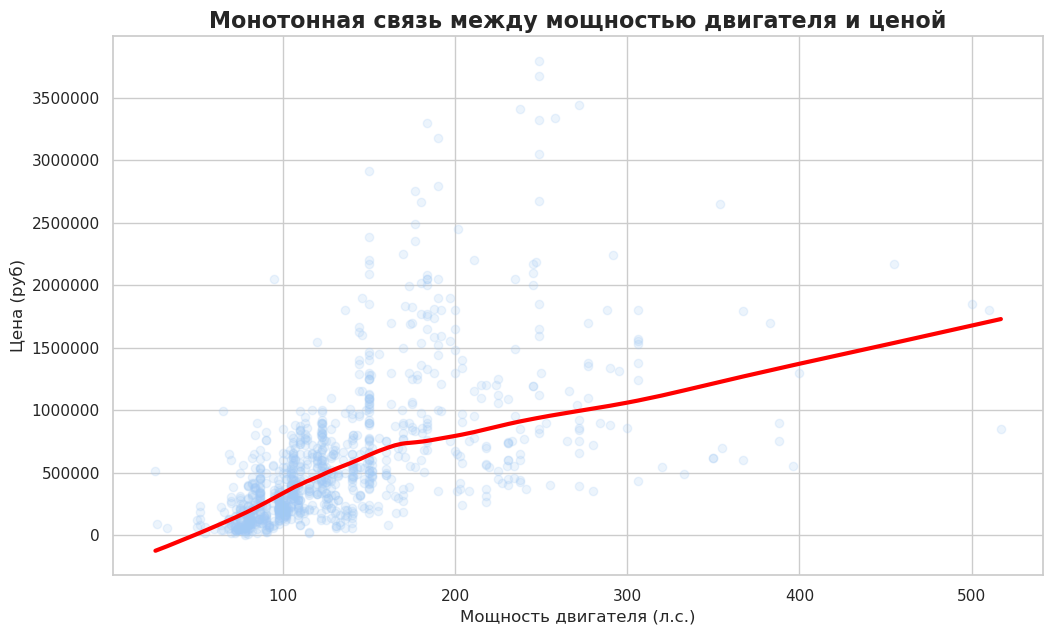


--- Результаты корреляции Спирмена: Мощность vs. Цена ---

Коэффициент корреляции (rho): 0.707
P-value: 0.00000

✅ Вывод: P-value < 0.05. Отвергаем нулевую гипотезу об отсутствии связи.
Существует сильная положительная монотонная связь: чем выше мощность, тем выше цена.


In [48]:
temp_df = df_clean[['engine_power_hp', 'price']].dropna()

plt.figure(figsize=(12, 7))
sns.regplot(data=temp_df.sample(n=min(1000, len(temp_df))), 
            x='engine_power_hp',
            y='price',
            lowess=True,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red', 'lw': 3})
plt.title('Монотонная связь между мощностью двигателя и ценой', fontsize=16, weight='bold')
plt.xlabel('Мощность двигателя (л.с.)', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

corr_coeff, p_value = stats.spearmanr(temp_df['engine_power_hp'], temp_df['price'])

print("\n--- Результаты корреляции Спирмена: Мощность vs. Цена ---\n")
print(f"Коэффициент корреляции (rho): {corr_coeff:.3f}")
print(f"P-value: {p_value:.5f}\n")

if p_value < 0.05:
    print("✅ Вывод: P-value < 0.05. Отвергаем нулевую гипотезу об отсутствии связи.")
    if corr_coeff > 0:
        print("Существует сильная положительная монотонная связь: чем выше мощность, тем выше цена.")
    else:
        print("Существует сильная отрицательная монотонная связь: чем выше мощность, тем ниже цена.")
else:
    print("❌ Вывод: P-value >= 0.05. Не можем отвергнуть нулевую гипотезу.")
    print("Нет достаточных оснований для вывода о наличии монотонной связи.")

## Интерпретация и вывод для Гипотезы 6

1. **Анализ коэффициента корреляции**: Значение `rho`, равное `0.706`, указывает на наличие **сильной положительной монотонной связи**. Это означает, что при **увеличении мощности двигателя цена также стабильно и предсказуемо возрастает**.

2. **Анализ P-value**: Значение `p-value (0.00000)` меньше уровня значимости `α (0.05)`.

3. **Статистическое решение**: Мы уверенно **отвергаем нулевую гипотезу** *(H₀)* об отсутствии связи.

### Итоговый вывод:

**Существует очень сильная и статистически значимая положительная монотонная связь между мощностью двигателя и ценой. Это подтверждает, что мощность является одним из ключевых драйверов цены, и эта зависимость стабильна по всему диапазону значений, даже если она не является идеально линейной.**

---

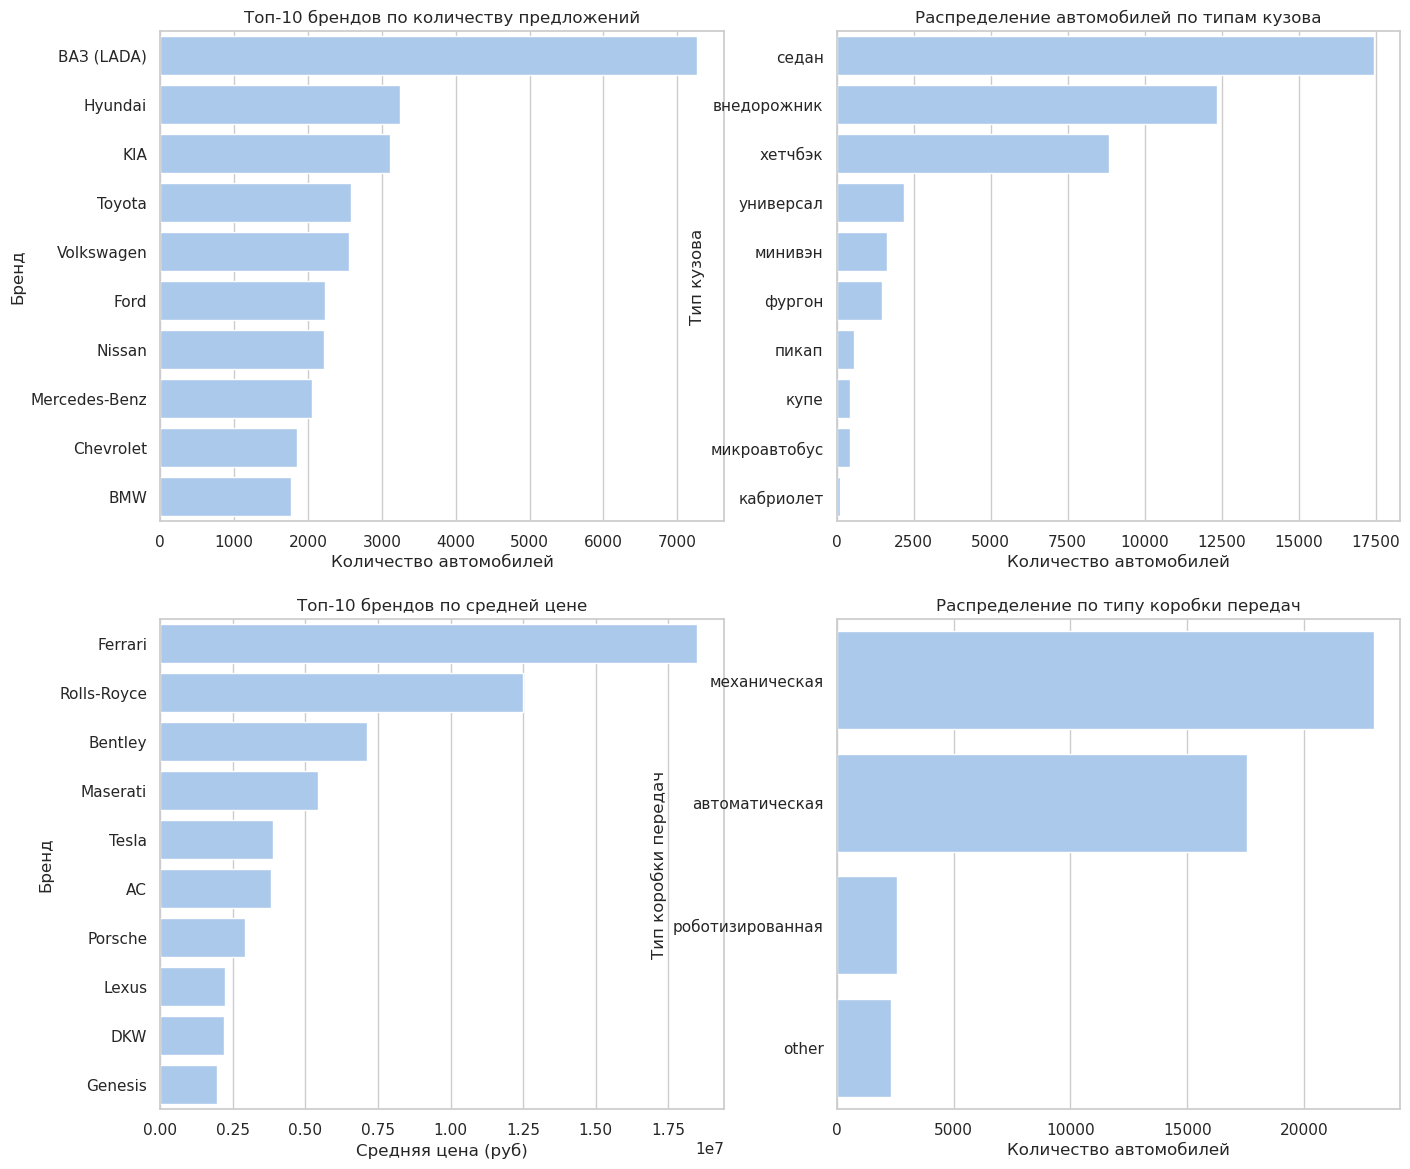

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

brand_counts = df['brand'].value_counts().head(10)
sns.barplot(x=brand_counts.values, y=brand_counts.index, ax=axes[0, 0])
axes[0, 0].set_title('Топ-10 брендов по количеству предложений')
axes[0, 0].set_xlabel('Количество автомобилей')
axes[0, 0].set_ylabel('Бренд')

body_type_counts = df['body_type'].value_counts()
sns.barplot(x=body_type_counts.values, y=body_type_counts.index, ax=axes[0, 1])
axes[0, 1].set_title('Распределение автомобилей по типам кузова')
axes[0, 1].set_xlabel('Количество автомобилей')
axes[0, 1].set_ylabel('Тип кузова')

top_brands = df.groupby('brand')['price'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, ax=axes[1, 0])
axes[1, 0].set_title('Топ-10 брендов по средней цене')
axes[1, 0].set_xlabel('Средняя цена (руб)')
axes[1, 0].set_ylabel('Бренд')

transmission_counts = df['vehicle_transmission'].value_counts()
sns.barplot(x=transmission_counts.values, y=transmission_counts.index, ax=axes[1, 1])
axes[1, 1].set_title('Распределение по типу коробки передач')
axes[1, 1].set_xlabel('Количество автомобилей')
axes[1, 1].set_ylabel('Тип коробки передач');

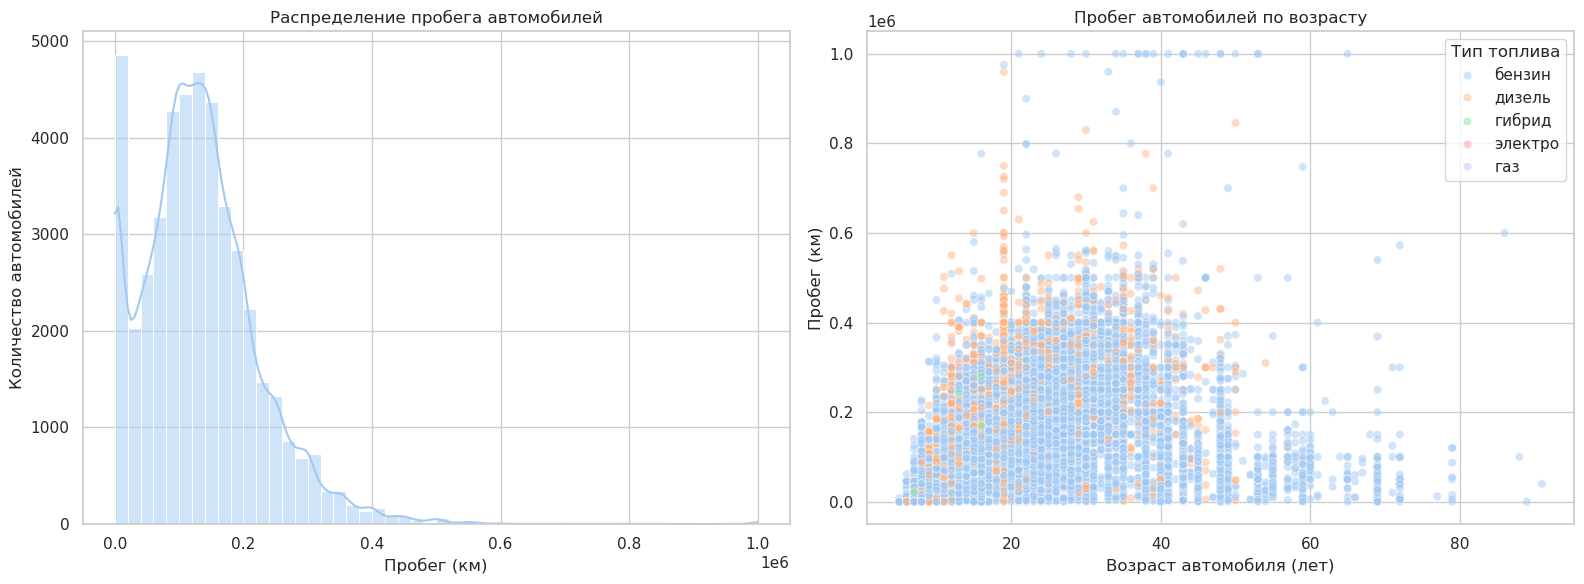

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['mileage'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Распределение пробега автомобилей')
axes[0].set_xlabel('Пробег (км)')
axes[0].set_ylabel('Количество автомобилей')

df['vehicle_age'] = 2025 - df['production_date']  
sns.scatterplot(
    x='vehicle_age', 
    y='mileage', 
    data=df, 
    alpha=0.5, 
    hue='fuel_type',
    ax=axes[1]
)
axes[1].set_title('Пробег автомобилей по возрасту')
axes[1].set_xlabel('Возраст автомобиля (лет)')
axes[1].set_ylabel('Пробег (км)')
axes[1].legend(title='Тип топлива')

plt.tight_layout()
plt.show()

In [51]:
price_stats = df_clean.groupby('brand')['price'].agg(['min', 'max', 'median']).reset_index()
price_stats_q = df_clean.groupby('brand')['price'].quantile([0.25, 0.75]).unstack().reset_index()
price_stats = pd.merge(price_stats, price_stats_q, on='brand')
price_stats = price_stats.sort_values('median').rename(columns={0.25: 'q1', 0.75: 'q3'})

fig = go.Figure(data=[go.Candlestick(
    x=price_stats['brand'],
    open=price_stats['q1'],
    high=price_stats['max'],
    low=price_stats['min'],
    close=price_stats['q3'],
    hovertext=price_stats.apply(lambda r: f"Медиана: {r['median']:.0f} руб<br>Разброс: {r['min']:.0f} - {r['max']:.0f} руб", axis=1),
    hoverinfo="text"
)])

fig.update_layout(
    title_text="Анализ цен по маркам (Японские свечи)",
    xaxis_title="Марка автомобиля",
    yaxis_title="Цена (руб)",
    xaxis_rangeslider_visible=False 
)
fig.show(renderer='iframe_connected')

In [52]:
fig = px.treemap(df, 
                 path=[px.Constant("Все марки"), 'brand', 'body_type'], 
                 values='price', 
                 color='body_type',
                 title='Иерархия марок и типов кузова на рынке',
                )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show(renderer='iframe_connected')

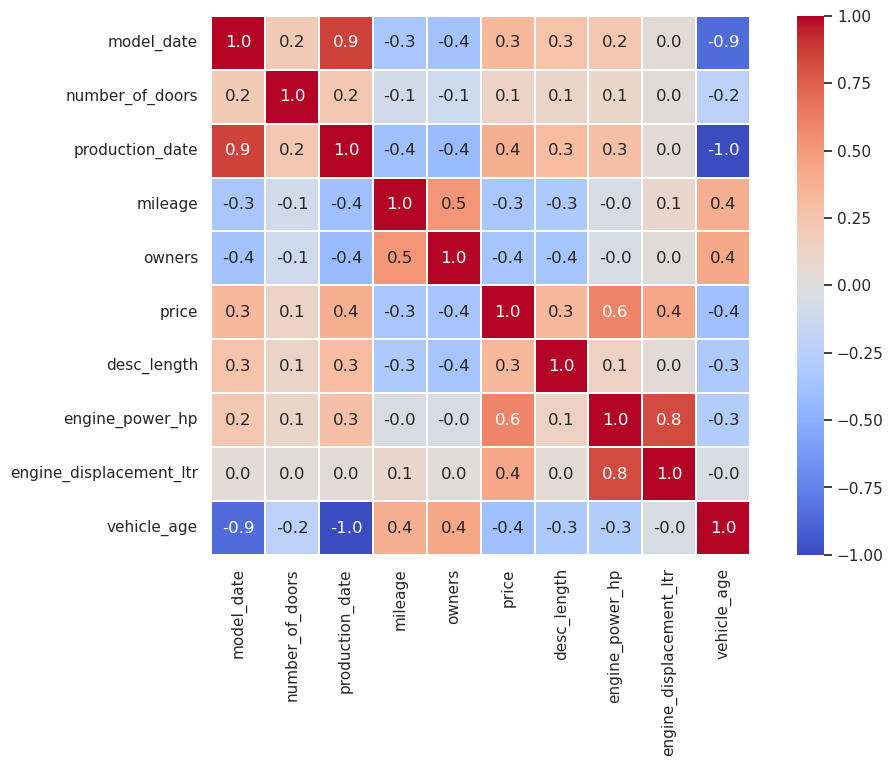

In [53]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, square=True,
            annot=True, fmt='.1f', linewidths=0.1, cmap='coolwarm');

Исходное количество строк: 45438
Данные подготовлены. Количество признаков после OHE: 148

DBSCAN нашел 7448 шумовых точек (выбросов).
Запуск t-SNE для визуализации... (может занять время)


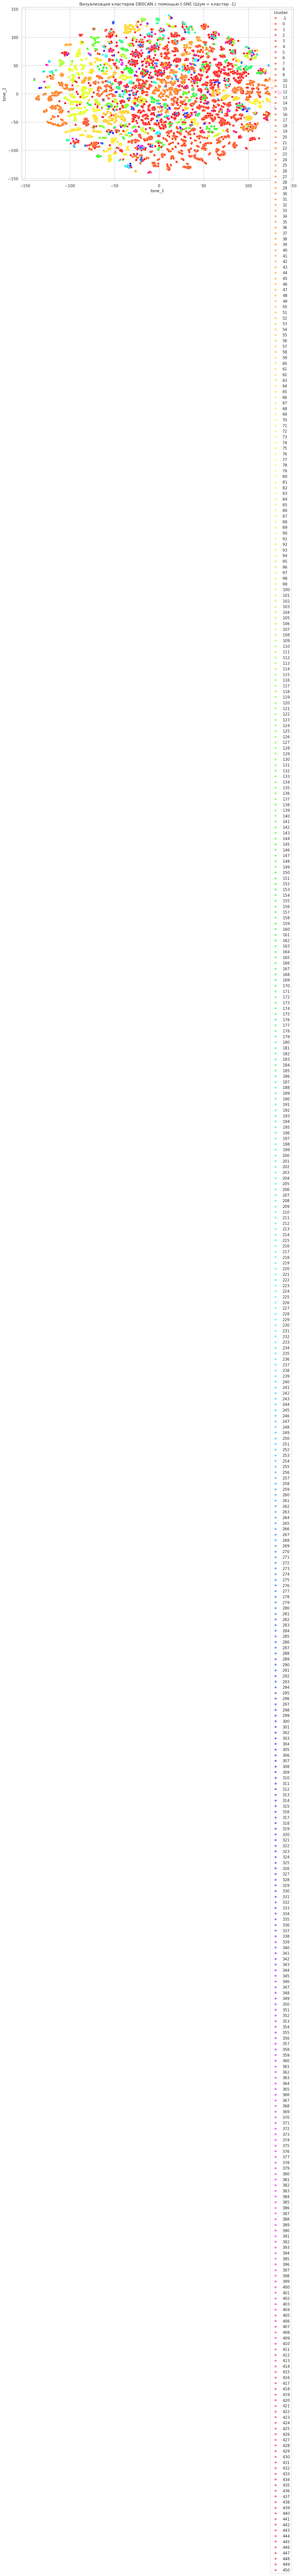


Удалено 7448 строк (16.39% данных).
Итоговое количество строк: 37990


In [55]:
def clean_and_visualize_dbscan(df, columns_to_use, eps=0.5, min_samples=5):
    """
    Находит выбросы с помощью DBSCAN, визуализирует их через t-SNE и возвращает очищенный DataFrame.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    print(f"Исходное количество строк: {initial_rows}")

    data_subset = df_out[columns_to_use]
    
    data_processed = pd.get_dummies(data_subset, drop_first=True)
    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    
    print(f"Данные подготовлены. Количество признаков после OHE: {data_scaled.shape[1]}")
    
    # Кластеризация DBSCAN
    # eps и min_samples - ключевые параметры, их нужно подбирать под ваши данные!
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    cluster_labels = dbscan.fit_predict(data_scaled)
    df_out['cluster'] = cluster_labels
    
    noise_points_count = (df_out['cluster'] == -1).sum()
    print(f"\nDBSCAN нашел {noise_points_count} шумовых точек (выбросов).")
    
    # Визуализация t-SNE
    print("Запуск t-SNE для визуализации... (может занять время)")
    # UMAP часто работает быстрее: from umap import UMAP; tsne = UMAP(n_components=2)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    data_tsne = tsne.fit_transform(data_scaled)
    
    df_out['tsne_1'] = data_tsne[:, 0]
    df_out['tsne_2'] = data_tsne[:, 1]
    
    plt.figure(figsize=(14, 9))
    sns.scatterplot(
        x='tsne_1', y='tsne_2',
        hue='cluster',
        palette=sns.color_palette("hsv", len(set(cluster_labels))),
        data=df_out,
        legend="full",
        alpha=0.6
    )
    plt.title('Визуализация кластеров DBSCAN с помощью t-SNE (Шум = кластер -1)')
    plt.show()
    
    df_cleaned = df_out[df_out['cluster'] != -1].drop(columns=['cluster', 'tsne_1', 'tsne_2'])
    final_rows = len(df_cleaned)
    
    print(f"\nУдалено {initial_rows - final_rows} строк ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% данных).")
    print(f"Итоговое количество строк: {final_rows}")
    
    return df_cleaned

df_cluster = df.copy()

# Выбираем признаки. Сюда можно включать важные категориальные признаки.
# Избегаем признаков с тысячами уникальных значений (как 'name', 'equipment')
cols_for_cluster = [
    'body_type', 'brand', 'color', 'fuel_type', 'vehicle_transmission', 'drive',
    'price', 'mileage', 'engine_power_hp', 'owners', 'vehicle_age'
]

# ВАЖНО: Подбор `eps` и `min_samples` — это отдельная задача.
# Начните с значений по умолчанию и настраивайте, глядя на результат.
# Для данных с большим количеством признаков `eps` может потребовать увеличения.
# Попробуем с более высоким `eps` из-за большого кол-ва признаков после OHE.
df_cleaned_cluster = clean_and_visualize_dbscan(df_cluster, cols_for_cluster, eps=3.0, min_samples=10)

In [56]:
def clean_with_isolation_forest(df, columns, contamination=0.01):
    """
    Очищает DataFrame от выбросов с помощью Isolation Forest.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    
    print(f"Исходное количество строк: {initial_rows}")

    # Выбираем только указанные числовые столбцы для модели
    data_for_iso = df_out[columns].select_dtypes(include=np.number)
    
    # Инициализируем и обучаем модель
    # contamination - предполагаемая доля выбросов. 'auto' - хороший старт.
    # можно задать конкретное значение, например, 0.01 (1%)
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42, n_jobs=-1)
    predictions = iso_forest.fit_predict(data_for_iso)
    
    # Добавляем предсказания в DataFrame
    df_out['anomaly'] = predictions
    
    # Считаем количество выбросов
    num_anomalies = (df_out['anomaly'] == -1).sum()
    
    # Удаляем выбросы
    df_out = df_out[df_out['anomaly'] == 1].drop(columns='anomaly')
    
    final_rows = len(df_out)
    
    print(f"Найдено и удалено {num_anomalies} аномальных строк ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% данных).")
    print(f"Итоговое количество строк: {final_rows}")
    
    return df_out

df_iso = df.copy()

cols_for_iso = ['price', 'mileage', 'engine_power_hp', 'engine_displacement_ltr', 
                'production_date', 'owners', 'vehicle_age']
df_cleaned_cluster
df_cleaned_iso = clean_with_isolation_forest(df_iso, cols_for_iso, contamination=0.05)

Исходное количество строк: 45438
Найдено и удалено 2272 аномальных строк (5.00% данных).
Итоговое количество строк: 43166


In [57]:
def remove_outliers_iqr(df, columns):
    """
    Удаляет строки с выбросами в указанных столбцах на основе 1.5*IQR правила.
    """
    df_out = df.copy()
    initial_rows = len(df_out)
    
    print(f"Исходное количество строк: {initial_rows}")
    
    # Создаем индекс для отслеживания строк, подлежащих удалению
    indices_to_drop = set()

    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Находим индексы выбросов для текущего столбца
        outliers_indices = df_out[(df_out[col] < lower_bound) | (df_out[col] > upper_bound)].index
        print(f"В столбце '{col}' найдено {len(outliers_indices)} выбросов.")
        
        # Добавляем их в общий набор индексов
        indices_to_drop.update(outliers_indices)
        
    # Удаляем все строки с выбросами за один раз
    df_out = df_out.drop(index=list(indices_to_drop))
    final_rows = len(df_out)
    
    print(f"\nУдалено {initial_rows - final_rows} строк ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% данных).")
    print(f"Итоговое количество строк: {final_rows}")
    
    return df_out

df_iqr = df.copy()

numeric_cols_for_iqr = df.select_dtypes(include=[np.number])
df_cleaned_iqr = remove_outliers_iqr(df_iqr, numeric_cols_for_iqr)

Исходное количество строк: 45438
В столбце 'model_date' найдено 2764 выбросов.
В столбце 'number_of_doors' найдено 1462 выбросов.
В столбце 'production_date' найдено 2755 выбросов.
В столбце 'mileage' найдено 1185 выбросов.
В столбце 'owners' найдено 0 выбросов.
В столбце 'price' найдено 3936 выбросов.
В столбце 'desc_length' найдено 3298 выбросов.
В столбце 'engine_power_hp' найдено 4474 выбросов.
В столбце 'engine_displacement_ltr' найдено 2982 выбросов.
В столбце 'vehicle_age' найдено 2755 выбросов.

Удалено 13537 строк (29.79% данных).
Итоговое количество строк: 31901


In [58]:
def clean_with_kmeans_distance(df, columns_to_use, n_clusters=15, outlier_percentile=99):
    """
    Находит и удаляет выбросы на основе расстояния до центроидов K-Means.
    """
    
    df_out = df.copy()
    initial_rows = len(df_out)
    
    print(f"Исходное количество строк: {initial_rows}")

    data_subset = df_out[columns_to_use]
    data_processed = pd.get_dummies(data_subset, drop_first=True)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_processed)
    print(f"Данные подготовлены. Количество признаков после OHE: {data_scaled.shape[1]}")

    # Применение K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    
    # Идентификация выбросов
    # Вычисляем расстояние от каждой точки до ВСЕХ центроидов
    distances = cdist(data_scaled, kmeans.cluster_centers_, 'euclidean')
    
    # Для каждой точки берем расстояние до ее собственного кластера
    min_distances = np.min(distances, axis=1)
    
    # Определяем порог как перцентиль этих минимальных расстояний
    threshold = np.percentile(min_distances, outlier_percentile)
    print(f"\nПорог расстояния для выбросов: {threshold:.2f}")

    df_out['is_outlier'] = min_distances > threshold
    num_anomalies = df_out['is_outlier'].sum()
    
    df_cleaned = df_out[~df_out['is_outlier']].drop(columns='is_outlier')
    
    final_rows = len(df_cleaned)
    
    print(f"K-Means нашел и удалил {num_anomalies} аномальных строк.")
    print(f"Итоговое количество строк: {final_rows} ({((initial_rows - final_rows) / initial_rows) * 100:.2f}% удалено)")
    
    return df_cleaned

df_kmeans = df.copy()

cols_for_cluster = [
    'body_type', 'brand', 'color', 'fuel_type', 'vehicle_transmission', 'drive',
    'price', 'mileage', 'engine_power_hp', 'owners', 'vehicle_age'
]

df_cleaned_kmeans = clean_with_kmeans_distance(df_kmeans, cols_for_cluster, n_clusters=20, outlier_percentile=95)

Исходное количество строк: 45438
Данные подготовлены. Количество признаков после OHE: 148

Порог расстояния для выбросов: 15.62
K-Means нашел и удалил 2270 аномальных строк.
Итоговое количество строк: 43168 (5.00% удалено)


In [60]:
df_cleaned_kmeans.drop(columns=['number_of_doors', 'steering_wheel', 'body_type_extracted', 'desc_length'], 
                       axis=1, 
                       inplace=True)

df_cleaned_kmeans.to_csv('../../data/processed/kmeans_clean_data.csv')
                           
df_cleaned_iqr.drop(columns=['number_of_doors', 'steering_wheel', 'body_type_extracted', 'desc_length'], 
                    axis=1, 
                    inplace=True)

df_cleaned_iqr.to_csv('../../data/processed/iqr_clean_data.csv')
                        
df_cleaned_cluster.drop(columns=['number_of_doors', 'steering_wheel', 'body_type_extracted', 'desc_length'], 
                        axis=1,
                        inplace=True)

df_cleaned_cluster.to_csv('../../data/processed/dbscan_clean_data.csv')
                            
df_cleaned_iso.drop(columns=['number_of_doors', 'steering_wheel', 'body_type_extracted', 'desc_length'], 
                    axis=1, 
                    inplace=True)

df_cleaned_iso.to_csv('../../data/processed/iso_clean_data.csv')

## Feature engineering 

---

In [61]:
PREMIUM_BRANDS = [
    'Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Lexus', 
    'Land Rover', 'Bentley', 'Maserati', 'Ferrari', 'Rolls-Royce',
    'Jaguar', 'Tesla', 'Genesis', 'Infiniti', 'Acura', 'Cadillac',
    'Volvo', 'Lincoln'
]

In [62]:
def optimized_car_feature_engineering(df, current_year=2025):
    """
    Создает новые признаки для автомобильного датасета с учетом требований
    :param df: Исходный DataFrame
    :param current_year: Текущий год для расчета возраста
    :return: DataFrame с новыми признаками
    """
    df = df.copy()
    
    # 1. Основные технические характеристики
    df['power_per_liter'] = df['engine_power_hp'] / df['engine_displacement_ltr']
    df['power_per_liter'] = df['power_per_liter'].replace([np.inf, -np.inf], np.nan)
    df['power_per_liter'] = df['power_per_liter'].fillna(df['engine_power_hp'])
    
    # 2. Временные характеристики
    df['vehicle_age'] = current_year - df['production_date']
    df['model_recency'] = df['model_date'] - df['production_date']
    df['mileage_per_year'] = df['mileage'] / df['vehicle_age'].replace(0, 1)
    
    # 3. Логарифмирование только цены 
    df['log_price'] = np.log1p(df['price'])
    
    # 4. Признак классического цвета
    classic_colors = ['белый', 'чёрный', 'серый', 'серебряный']
    df['is_classic_color'] = df['color'].apply(lambda x: 1 if x in classic_colors else 0)
    
    # 5. Группировочные признаки
    brand_price_avg = df.groupby('brand')['price'].transform('mean')
    df['price_brand_ratio'] = df['price'] / brand_price_avg.replace(0, 1)
    
    body_type_power_avg = df.groupby('body_type')['engine_power_hp'].transform('mean')
    df['power_bodytype_ratio'] = df['engine_power_hp'] / body_type_power_avg.replace(0, 1)
    
    # 6. Редкость автомобиля
    brand_body_counts = df.groupby(['brand', 'body_type']).size()
    df['rarity_score'] = df.apply(
        lambda x: 1 / brand_body_counts.get((x['brand'], x['body_type']), 1), axis=1
    )
    
    # 7. Признаки взаимодействия
    df['power_age_ratio'] = df['engine_power_hp'] / df['vehicle_age'].replace(0, 1)
    df['mileage_age_product'] = df['mileage'] * df['vehicle_age']
    
    # 8. Премиальность бренда (обновленный список)
    df['is_premium'] = df['brand'].apply(lambda x: 1 if x in PREMIUM_BRANDS else 0)
    
    # 9. Состояние автомобиля
    df['is_damaged'] = df['condition'].apply(lambda x: 1 if x == 'битый' else 0)
    
    return df

In [63]:
df_cluster_engineered = optimized_car_feature_engineering(df_cleaned_cluster)
df_iso_engineered = optimized_car_feature_engineering(df_cleaned_iso)
df_iqr_engineered = optimized_car_feature_engineering(df_cleaned_iqr)
df_kmeans_engineered = optimized_car_feature_engineering(df_cleaned_kmeans)

In [64]:
def remove_multicollinearity(df):
    """
    Удаляет мультиколлинеарные признаки на основе корреляционного анализа
    Возвращает очищенный DataFrame и список удаленных признаков
    """
    df_clean = df.copy()
    
    removed_features = []
    
    # 1. Удаление полностью коррелирующих признаков
    if 'vehicle_age' in df_clean.columns:
        df_clean.drop('vehicle_age', axis=1, inplace=True)
        removed_features.append('vehicle_age')
    
    # 2. Удаление дублирующих производных признаков
    redundant_features = [
        'mileage_age_product',  # Синтетический признак
        'model_recency',        # Низкая информативность
        'power_age_ratio',      # Дублирует информацию о мощности
    ]
    
    for feature in redundant_features:
        if feature in df_clean.columns:
            df_clean.drop(feature, axis=1, inplace=True)
            removed_features.append(feature)
    
    # 3. Агрегация коррелирующих признаков
    # Объединяем связанные признаки в группы
    correlated_groups = {
        'engine_metrics': ['engine_power_hp', 'engine_displacement_ltr', 'power_per_liter'],
        'date_metrics': ['model_date', 'production_date'],
        'mileage_metrics': ['mileage', 'mileage_per_year']
    }
    
    # Оставляем самый информативный признак из каждой группы
    keep_features = {
        'engine_metrics': 'power_per_liter',
        'date_metrics': 'production_date',
        'mileage_metrics': 'mileage_per_year'
    }
    
    for group, keep_feature in keep_features.items():
        for feature in correlated_groups[group]:
            if feature != keep_feature and feature in df_clean.columns:
                df_clean.drop(feature, axis=1, inplace=True)
                removed_features.append(feature)
    
    # 4. Удаление низкодисперсных признаков
    low_variance_features = ['number_of_doors', 'rarity_score']
    for feature in low_variance_features:
        if feature in df_clean.columns:
            df_clean.drop(feature, axis=1, inplace=True)
            removed_features.append(feature)
    
    return df_clean, removed_features

In [65]:
df_cluster_cleaned, _ = remove_multicollinearity(df_cluster_engineered)

df_iso_cleaned, _ = remove_multicollinearity(df_iso_engineered)

df_iqr_cleaned, _ = remove_multicollinearity(df_iqr_engineered)

df_kmeans_cleaned, _ = remove_multicollinearity(df_kmeans_engineered)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import optuna
import joblib
import json

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from mlflow.pyfunc import PythonModel

MLFLOW_PARENT_DIR = "../../data/"
os.makedirs(MLFLOW_PARENT_DIR, exist_ok=True)

MLFLOW_TRACKING_URI = os.path.join(MLFLOW_PARENT_DIR, "mlflow") 
EXPERIMENT_NAME = "Car_Price_Prediction"

RANDOM_STATE = 42
N_TRIALS = 50
CV_FOLDS = 5

In [67]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

def setup_mlflow_experiment():
    """Создает структуру эксперимента в MLflow"""
    client = mlflow.tracking.MlflowClient()
    try:
        exp_id = client.create_experiment(EXPERIMENT_NAME)
    except:
        exp_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
    
    client.set_experiment_tag(exp_id, "project", "Car Price Prediction")
    client.set_experiment_tag(exp_id, "platform", "Host")
    
    return exp_id

2025/06/24 01:10:08 INFO mlflow.tracking.fluent: Experiment with name 'Car_Price_Prediction' does not exist. Creating a new experiment.


In [68]:
def log_dataset_info(dataset_name, df):
    """Логирует информацию о датасете как артефакт"""
    dataset_info = {
        "name": dataset_name,
        "shape": df.shape,
        "columns": list(df.columns),
        "description": f"Processed dataset for car price prediction ({dataset_name} method)"
    }
    
    info_path = f"{dataset_name}_info.json"
    with open(info_path, 'w') as f:
        json.dump(dataset_info, f)
    
    mlflow.log_artifact(info_path)
    os.remove(info_path)

In [69]:
BEST_PARAMS = {
    'price': {
        'RandomForest': {
            'n_estimators': 167,
            'max_depth': 22,
            'min_samples_split': 4,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        },
        'GradientBoosting': {
            'n_estimators': 478,
            'learning_rate': 0.18832603959129451,
            'max_depth': 3,
            'min_samples_split': 19,
            'min_samples_leaf': 7,
            'subsample': 0.9605340329763895,
            'random_state': RANDOM_STATE
        },
        'XGBoost': {
            'n_estimators': 984,
            'max_depth': 3,
            'learning_rate': 0.14447501525935036,
            'subsample': 0.8147159243023041,
            'colsample_bytree': 0.8016299233149149,
            'gamma': 0.9012103225265303,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    },
    'log_price': {
        'RandomForest': {
            'n_estimators': 456,
            'max_depth': 24,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 1.0,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        },
        'GradientBoosting': {
            'n_estimators': 427,
            'learning_rate': 0.12565526763028434,
            'max_depth': 5,
            'min_samples_split': 13,
            'min_samples_leaf': 1,
            'subsample': 0.8786792393523636,
            'random_state': RANDOM_STATE
        },
        'XGBoost': {
            'n_estimators': 300,
            'max_depth': 6,
            'learning_rate': 0.08584985502667564,
            'subsample': 0.898347884401677,
            'colsample_bytree': 0.8900743750424372,
            'gamma': 0.00204804746740328,
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    }
}

In [70]:
def prepare_data(df, target='price'):
    """Подготовка данных с выбором целевой переменной"""
    if target == 'log_price':
        df = df.drop(columns=['price'], errors='ignore')
        y = df['log_price']
    else:
        df = df.drop(columns=['log_price'], errors='ignore')
        y = df['price']
    
    X = df.drop(columns=[y.name])
    return X, y

In [71]:
numerical_features = [
    'production_date', 'power_per_liter', 
    'mileage_per_year', 'price_brand_ratio', 'power_bodytype_ratio',
    'owners'
]

categorical_features_ohe = [
    'body_type', 'fuel_type', 'drive', 
    'condition', 'pts', 'customs_cleared'
]

categorical_features_te = ['name', 'equipment', 'brand', 'vehicle_transmission']

binary_features = ['is_classic_color', 'is_premium', 'is_damaged']

In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_ohe),
        ('te', TargetEncoder(), categorical_features_te),
        ('binary', 'passthrough', binary_features)
    ]
)

In [73]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_class, target_type):
    """Обучение и оценка модели с предустановленными параметрами"""
    params = BEST_PARAMS[target_type].get(model_class, {})
    
    if model_class == 'XGBoost':
        model = XGBRegressor(**params)
    elif model_class == 'RandomForest':
        model = RandomForestRegressor(**params)
    elif model_class == 'GradientBoosting':
        model = GradientBoostingRegressor(**params)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return pipeline, rmse, r2

In [ ]:
def run_full_pipeline(df, dataset_name, parent_run):
    """Запуск пайплайна с фиксированными параметрами"""
    exp_id = setup_mlflow_experiment()
    
    local_models_dir = "models"
    os.makedirs(local_models_dir, exist_ok=True)
    
    with mlflow.start_run(run_name=f"Dataset_{dataset_name}", nested=True, 
                         parent_run_id=parent_run.info.run_id):
        log_dataset_info(dataset_name, df)
        
        results = {}
        
        for target_type in ['price', 'log_price']:
            with mlflow.start_run(run_name=f"Target_{target_type}", nested=True):
                X, y = prepare_data(df, target_type)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=RANDOM_STATE
                )
                
                mlflow.log_param("target", target_type)
                mlflow.log_param("test_size", 0.2)
                mlflow.log_param("random_state", RANDOM_STATE)
                
                target_results = {}
                models_to_run = ['RandomForest', 'GradientBoosting', 'XGBoost']
                
                for model_class in models_to_run:
                    with mlflow.start_run(run_name=model_class, nested=True):
                        mlflow.set_tag("model_type", model_class)
                        
                        model_pipeline, rmse, r2 = train_and_evaluate(
                            X_train, y_train, X_test, y_test, 
                            model_class, target_type
                        )
                        
                        target_results[model_class] = {
                            'model': model_pipeline,
                            'rmse': rmse,
                            'r2': r2
                        }
                        
                        print(f"Результаты для {model_class} ({target_type}):")
                        print(f"  RMSE: {rmse:.4f}")
                        print(f"  R²: {r2:.4f}")
                        
                        mlflow.log_metric("RMSE", rmse)
                        mlflow.log_metric("R2", r2)
                        
                        model_filename = f"{model_class}_{dataset_name}_{target_type}.pkl"
                        local_model_path = os.path.join(local_models_dir, model_filename)

                        joblib.dump(model_pipeline, local_model_path)
                        print(f"    Модель сохранена локально: {local_model_path}")

                        mlflow.log_artifact(local_model_path, artifact_path="pkl_models")
                        print(f"    Модель залогирована как артефакт в MLflow.")
                        
                        signature = infer_signature(X_train, model_pipeline.predict(X_train))
                        
                        mlflow.sklearn.log_model(
                            sk_model=model_pipeline,
                            artifact_path="model",
                            signature=signature,
                            registered_model_name=f"{model_class}_{dataset_name}_{target_type}"
                        )
                
                results[target_type] = target_results
        
        return results

In [75]:
def compare_results(all_results):
    """Сравнение результатов для разных датасетов и моделей"""
    with mlflow.start_run(run_name="Results_Comparison", nested=True):
        comparison = []
        
        for dataset_name, dataset_results in all_results.items():
            for target_type, models in dataset_results.items():
                for model_name, metrics in models.items():
                    comparison.append({
                        'Dataset': dataset_name,
                        'Target': target_type,
                        'Model': model_name,
                        'RMSE': metrics['rmse'],
                        'R2': metrics['r2']
                    })
        
        df_comparison = pd.DataFrame(comparison)
        
        plt.figure(figsize=(16, 10))
        sns.barplot(
            x='RMSE', y='Model', hue='Target', 
            data=df_comparison, orient='h',
            order=df_comparison.groupby('Model')['RMSE'].mean().sort_values().index
        )
        plt.title('Сравнение RMSE по моделям и типам целевой переменной')
        plt.xlabel('RMSE')
        plt.ylabel('Модель')
        plt.tight_layout()
        
        plot_path = 'models_comparison.png'
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()
        
        mlflow.log_text(df_comparison.to_csv(index=False), "models_comparison.csv")
        
        return df_comparison

In [ ]:
if mlflow.active_run():
    mlflow.end_run()
    
exp_id = setup_mlflow_experiment()
    
with mlflow.start_run(run_name="Main_Experiment", experiment_id=exp_id) as parent_run:
    all_results = {}
    datasets = {
        'cluster': df_cluster_cleaned,
        'iso': df_iso_cleaned,
        'iqr': df_iqr_cleaned,
        'kmeans': df_kmeans_cleaned
    }
        
    mlflow.log_params({
        "test_size": 0.2,
        "random_state": RANDOM_STATE,
        "n_datasets": len(datasets)
    })
        
    for name, df in datasets.items():
        print(f"\n\n====== ОБРАБОТКА ДАТАСЕТА: {name.upper()} ======")
        results = run_full_pipeline(df, name, parent_run)
        all_results[name] = results
        print(f"\n===== ЗАВЕРШЕНО ДЛЯ ДАТАСЕТА: {name.upper()} =====")
        
    df_comparison = compare_results(all_results)
        
    best_models = {}
    for dataset, dataset_results in all_results.items():
        best_model_info = None
        best_rmse = float('inf')
        
        for target_type, models in dataset_results.items():
            for model_name, metrics in models.items():
                if metrics['rmse'] < best_rmse:
                    best_rmse = metrics['rmse']
                    best_model_info = {
                        "model": model_name,
                        "target": target_type,
                        "rmse": best_rmse
                    }
        
        best_models[dataset] = best_model_info
        
    mlflow.log_dict(best_models, "best_models.json")
    print("Эксперимент успешно завершен! Результаты сохранены в MLflow")



====== ОБРАБОТКА ДАТАСЕТА: CLUSTER ======


In [ ]:
# with mlflow.start_run(run_name="Main_Experiment"):
#         all_results = {}
#         datasets = {
#             'cluster': df_cluster_cleaned,
#             'iso': df_iso_cleaned,
#             'iqr': df_iqr_cleaned,
#             'lof': df_lof_cleaned,
#             'gmm': df_gmm_cleaned,
#             'kmeans': df_kmeans_cleaned
#         }
        
#         # Логируем параметры эксперимента
#         mlflow.log_param("n_trials", N_TRIALS)
#         mlflow.log_param("cv_folds", CV_FOLDS)
#         mlflow.log_param("random_state", RANDOM_STATE)
        
#         for name, df in datasets.items():
#             print(f"\n\n====== НАЧИНАЕМ ОБРАБОТКУ ДАТАСЕТА: {name.upper()} ======")
#             results = run_full_pipeline(df, name)
#             all_results[name] = results
#             print(f"\n===== ЗАВЕРШЕНО ДЛЯ ДАТАСЕТА: {name.upper()} =====")
        
#         # Сравнение результатов
#         df_comparison = compare_results_with_mlflow(all_results)

#         print("\nФинальная таблица сравнения:")
#         print(df_comparison.sort_values(by=['Dataset', 'RMSE']))

#         df_comparison.to_csv('all_models_comparison.csv', index=False)
#         joblib.dump(all_results, 'all_models_results.pkl')
        
#         # Сохраняем лучшие модели
#         best_models = {}
#         for dataset, models in all_results.items():
#             best_model = min(models.items(), key=lambda x: x[1]['rmse'])
#             best_models[dataset] = best_model
        
#         mlflow.log_dict(best_models, "best_models.json")
        
#         print("Эксперимент успешно завершен! Результаты сохранены в MLflow")

In [ ]:
def optimize_model(X, y, model_class, n_trials=N_TRIALS):
    """Оптимизация гиперпараметров с помощью Optuna"""
    
    # Определение пространства поиска для каждой модели
    def objective(trial):   
        if model_class == 'XGBoost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 9),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 1),
            }
            model = XGBRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
            
        elif model_class == 'RandomForest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2']),
            }
            model = RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
            
        elif model_class == 'GradientBoosting':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'max_depth': trial.suggest_int('max_depth', 3, 7),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            }
            model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
        
        # Пайплайн
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Кросс-валидация
        score = cross_val_score(
            pipeline, X, y, 
            cv=CV_FOLDS, 
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        ).mean()
        
        return score
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params, study.best_value